In [1]:
import cv2 as cv
import numpy as np
import os
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import matplotlib.patches as patches

import pandas as pd
import scipy as sp

from PIL import Image as im
import napari as nap

/Users/halensolomon/anaconda3/envs/fluids/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/halensolomon/anaconda3/envs/fluids/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/halensolomon/anaconda3/envs/fluids/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <77290B29-C58B-3DDF-9806-E74EFFDA9C4A> /Users/halensolomon/anaconda3/envs/fluids/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Hough Transform for Circle Detection 
(Do not need to do everytime unless mask has changed for some ungodly reason.)

In [2]:
img = cv.imread(r'/Users/halensolomon/Code/FLFM_local/testing/mask.tif', cv.IMREAD_GRAYSCALE)
min_radius = int(len(img[0,:])/9)

circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1.2, 1.5*min_radius, param1=70,param2=25, minRadius= min_radius,maxRadius=3*min_radius)
circles = np.uint16(np.around(circles))
circles = np.reshape(circles, (circles.shape[1], circles.shape[2]))

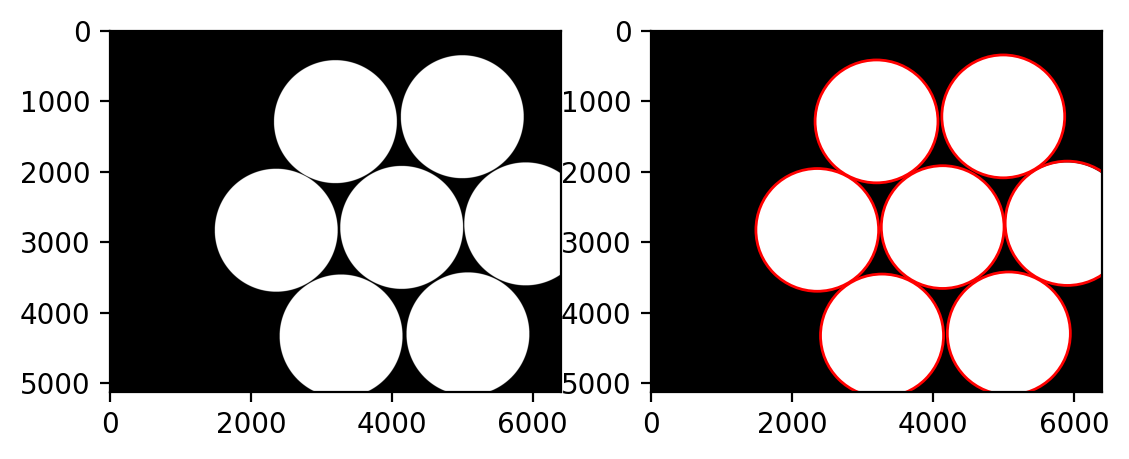

In [3]:
figure = plt.figure()
ax1, ax2 = figure.subplots(1,2)

for i in circles:
    # draw the outer circle
    #plt.imshow(cv.circle(img,(i[0],i[1]),i[2],(255,255,255),2))
    # draw the center of the circle
    circle = patches.Circle((i[0],i[1]),i[2], fill = False, color = 'r')
    ax2.add_patch(circle)
ax2.imshow(img, cmap= 'gray')
ax1.imshow(img, cmap= 'gray')

In [4]:
# Find which one is the center circle
circle_x_avg = np.mean(circles[:,0])
circle_y_avg = np.mean(circles[:,1])
circle_r_avg = np.mean(circles[:,2])

distances = []
theta = []

for i in range(len(circles[:,0])):
    x,y = circles[i,0]-circle_x_avg, circles[i,1]-circle_y_avg
    distances.append(np.sqrt((circles[i,0]-circle_x_avg)**2 + (circles[i,1]-circle_y_avg)**2))
    theta.append(np.arctan2(y,x))

theta = np.delete(theta, np.argmin(distances)) # Remove the center circle
distances = np.delete(distances, np.argmin(distances)) # Remove the center circle

theta = np.sort(theta) # Sort the angles
  
circle_theta_avg = np.mean(theta)
circle_theta_avg2 = (np.argmax(theta) - np.argmin(theta)) / (len(theta) - 1)
circle_dist_avg = np.mean(distances)

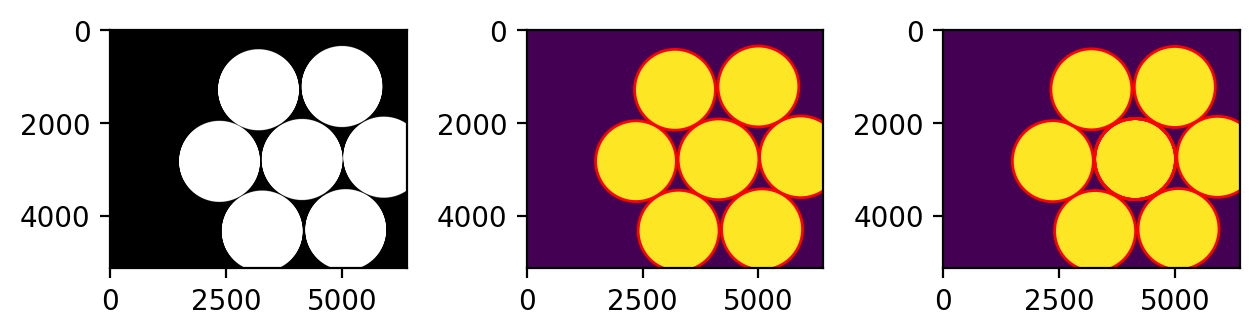

In [5]:
figure2 = plt.figure()
figure2.set_tight_layout(True)
ax1, ax2, ax3 = figure2.subplots(1,3)
ax1.imshow(img, cmap= 'gray')

for i in circles:
    # draw the outer circle
    circle = patches.Circle((i[0],i[1]),i[2], fill = False, color = 'r')
    ax2.add_patch(circle)
    ax2.imshow(img)

for i in range(len(theta)):
    # draw the center circle
    center = patches.Circle((circle_x_avg,circle_y_avg),circle_r_avg, fill = False, color = 'r')
    # Draw the outer circles by multiplying the average angle by i
    circle = patches.Circle((circle_x_avg+circle_dist_avg*np.cos(theta[i]),circle_y_avg+circle_dist_avg*np.sin(theta[i])),circle_r_avg, fill = False, color = 'r') # really good fit
    ax3.add_patch(center)
    ax3.add_patch(circle)
    ax3.imshow(img)

In [6]:
new_circles = np.array([circle_x_avg, circle_y_avg, circle_r_avg])

for i in range(len(theta)):
    new_circles = np.vstack((new_circles, (circle_x_avg+circle_dist_avg*np.cos(theta[i]), circle_y_avg+circle_dist_avg*np.sin(theta[i]), circle_r_avg))) # new circle centers and radii

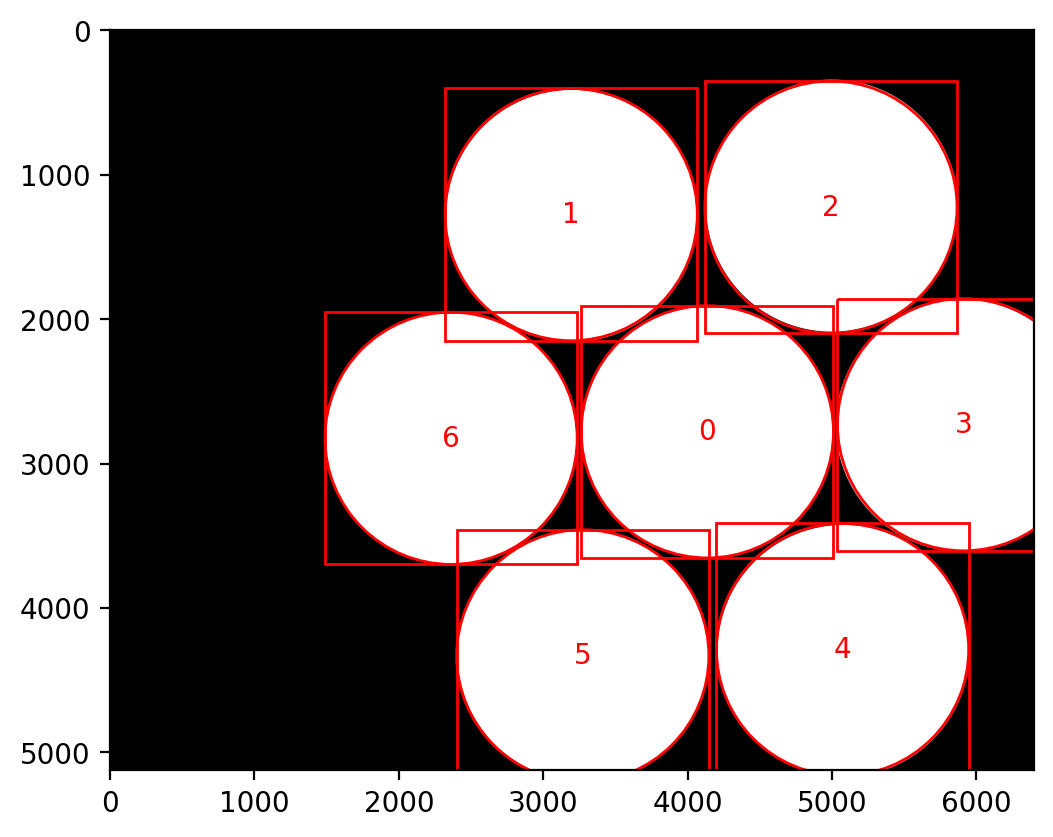

In [7]:
figure3 = plt.figure()
ax1 = figure3.subplots(1,1)

ax1.imshow(img, cmap= 'gray')

for i in range(len(new_circles[:,0])):
    # draw the outer circle
    squares = patches.Rectangle((new_circles[i,0]-new_circles[i,2], new_circles[i,1]-new_circles[i,2]), 2*new_circles[i,2], 2*new_circles[i,2], fill = False, color = 'r')
    circle = patches.Circle((new_circles[i,0],new_circles[i,1]),new_circles[i,2], fill = False, color = 'r')
    ax1.add_patch(squares)
    ax1.add_patch(circle)
    
    # Add the order of the circles in the center of each circle
    ax1.text(new_circles[i,0], new_circles[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')

# Just to test an idea, import two images

In [8]:
image_path = [r'/Users/halensolomon/Code/FLFM_local/testing/02.tif', r'/Users/halensolomon/Code/FLFM_local/testing/03.tif']
frames = []
for i in image_path:
    imge = im.open(i)
    frames.append(np.array(imge).astype(np.int16))

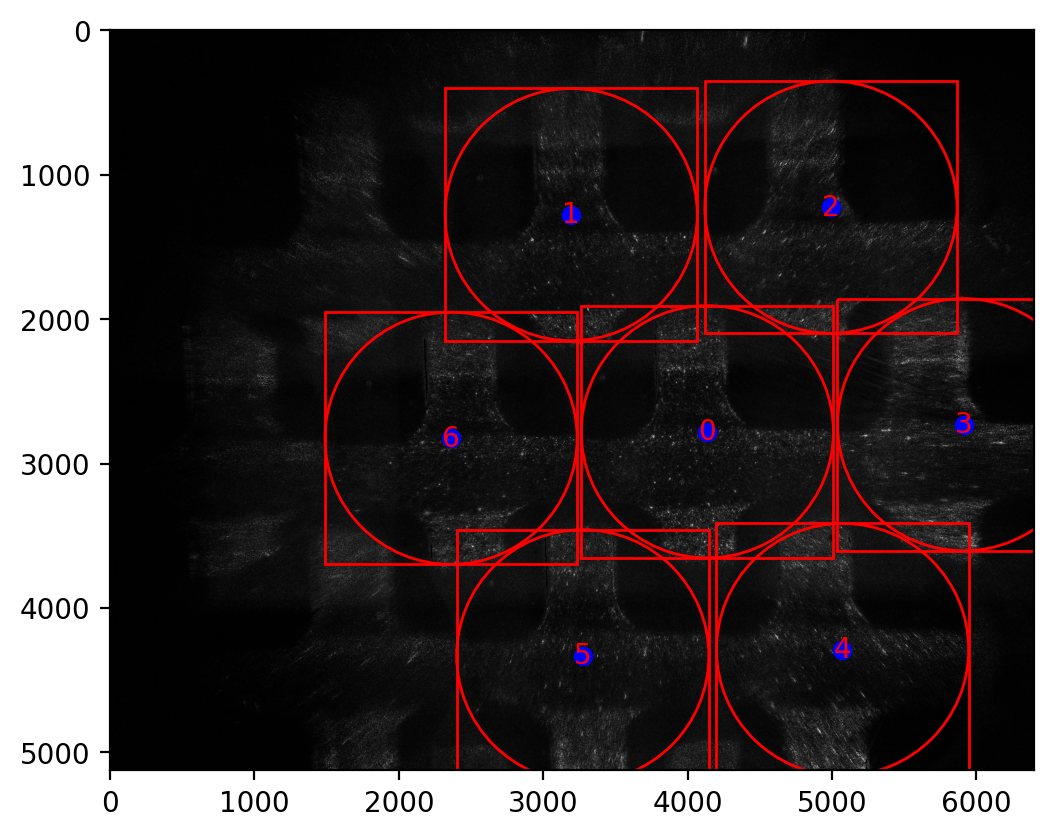

In [9]:
figure4 = plt.figure()
ax1 = figure4.subplots(1,1)

for i in range(len(new_circles[:,0])):
    # draw the outer circle
    squares = patches.Rectangle((new_circles[i,0]-new_circles[i,2], new_circles[i,1]-new_circles[i,2]), 2*new_circles[i,2], 2*new_circles[i,2], fill = False, color = 'r')
    circle = patches.Circle((new_circles[i,0],new_circles[i,1]),new_circles[i,2], fill = False, color = 'r')
    ax1.add_patch(squares)
    ax1.add_patch(circle)
    # Add the order of the circles in the center of each circle
    ax1.text(new_circles[i,0], new_circles[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')
    #plot the centers of the circles
    ax1.scatter(int(new_circles[i,0]), int(new_circles[i,1]), color = 'b')
    
ax1.imshow(frames[0], cmap= 'gray')

In [10]:
center_lenslet = int(0) # center circle index

In [11]:
# Check if the image is the same size as the calibration image
frames[0][:,:].shape == img.shape

True

In [12]:
lenslet_distances_og = np.zeros((len(new_circles[:,0]), len(new_circles[:,0])))
lenslet_angles = np.zeros((len(new_circles[:,0]), len(new_circles[:,0])))

for i in range(len(new_circles[:,0])):
    zero_to_i = new_circles[i,0] - new_circles[0,0]
    zero_to_i_1 = new_circles[i,1] - new_circles[0,1]

# Find the distances between the lenset centers
for i in range(len(new_circles[:,0])):
    for j in range(len(new_circles[:,0])):
        lenslet_distances_og[i,j] = (np.sqrt((new_circles[i,0]-new_circles[j,0])**2 + (new_circles[i,1]-new_circles[j,1])**2))
        lenslet_angles[i,j] = np.arctan2(new_circles[i,1]-new_circles[j,1], new_circles[i,0]-new_circles[j,0])

# Grab the 2nd diagonal of the matrix
lenslet_distances = np.diagonal(lenslet_distances_og, offset = 1)
lenslet_angles = np.diagonal(lenslet_angles, offset = 1)

#lenslet_angle_avg = np.mean(lenslet_angles)
lenslet_distance_avg = np.mean(lenslet_distances)
#print(lenslet_angles)
#print(lenslet_distance_avg, lenslet_angle_avg)

In [13]:
mask_array = np.zeros((int(2*new_circles[0,2]+1),int(2*new_circles[0,2]+1)))

# Create a circular mask that has 0s outside the circle and 1s inside the circle
for i in range(int(2*new_circles[0,2]+1)):
    r = new_circles[0,2]
    for j in range(int(2*new_circles[0,2]+1)):
        
        if np.sqrt((i-r)**2 + (j-r)**2) <= r: # Assuming the radius of the first circle is the same as the rest
            mask_array[i,j] = 1
        else:
            mask_array[i,j] = 0

mask_tensor = torch.from_numpy(mask_array)

In [14]:
perspectives = torch.zeros(int(len(frames)), int(len(new_circles[:,0])) , int(2*new_circles[0,2]+1), int(2*new_circles[0,2]+1)) # Making the different perspectives te "channels", also the frames are always odd numbers
# The first dimension is the frame number, the second dimension is the lenslet number, the third and fourth dimensions are the x and y dimensions of the lenslet

for i in range(len(frames)):
    for j in range(len(new_circles[:,0])):
        placeholder = torch.Tensor(frames[i][int(new_circles[j,1]-new_circles[j,2]):int(new_circles[j,1]+new_circles[j,2]), int(new_circles[j,0]-new_circles[j,2]):int(new_circles[j,0]+new_circles[j,2])]) # Don't know why x and y are switched
        
        if placeholder.shape == perspectives[0,0,:,:].shape:
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:]
            
        else:
            # If the circle is too close to the edge of the image, we need to pad it
            placeholder_x_deficit = int(2*new_circles[j,2]+1) - placeholder.shape[0]
            placeholder_y_deficit = int(2*new_circles[j,2]+1) - placeholder.shape[1]
            
            if placeholder_x_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
            if placeholder_x_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
                
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:] # This is the same as the placeholder, but padded with zeros if the circle is too close to the edge of the image

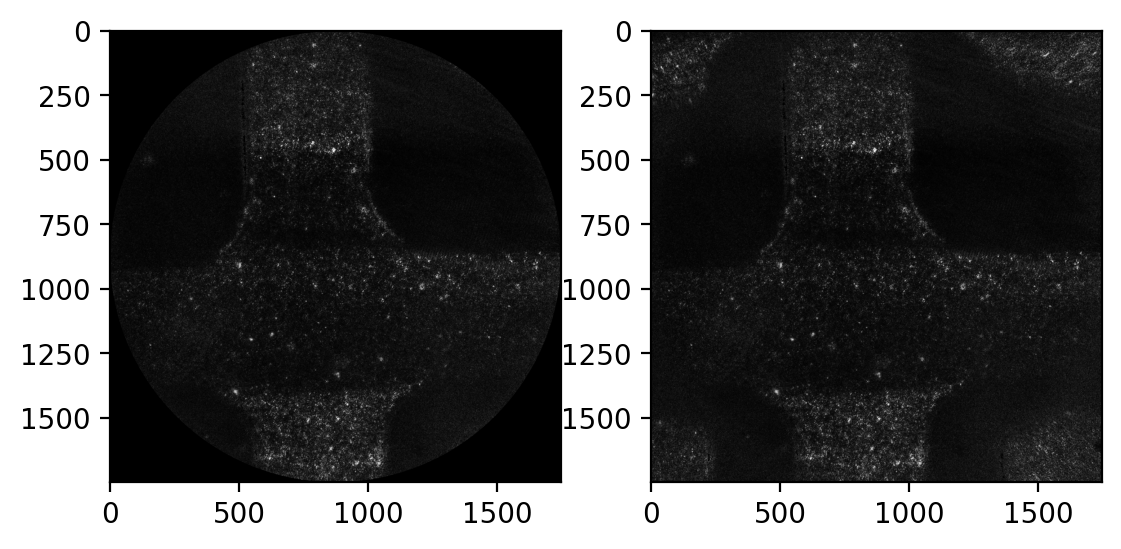

In [15]:
# Plotting the different perspectives
figure4 = plt.figure()
ax1,ax2 = figure4.subplots(1,2)

ith= int(1)
jth= int(0)

ax1.imshow(perspectives[ith,jth,:,:], cmap= 'gray')
ax2.imshow(frames[ith][int(new_circles[jth,1]-new_circles[jth,2]):int(new_circles[jth,1]+new_circles[jth,2]), int(new_circles[jth,0]-new_circles[jth,2]):int(new_circles[jth,0]+new_circles[jth,2])], cmap= 'gray')

# Frames loaded, rock and roll

### 4.2 Projection operators in FLFM

### Grabbed from FLFMconfigGW.yml

In [16]:
# Set-up Specific Constants

grid_Type = "hex"

NA = 0.4
fobj = 10000
f1 = 1
f2 = 1
fm = np.array([47000])

mla2sensor = 47000 # microns
lenspitch = 2520 # Lens pitch in microns 
pixel_size = 3.54 # Also referred to as pixel pitch in microns/px
refractive_index = 1 # Refractive index of the medium
wavelength = 0.5530

noLensHoriz = 3
noLensVert = 3

spacingPixels = 777
horizOffset = 1269
vertOffset = 690

shiftRow = 0
gridRot = 0

In [17]:
def FLFM_setCameraParams(config):
    # Config should be an array with the following parameters:
    # [NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot]
    
    objRad = config[0] * config[1] # Objective radius = NA * fobj
    k = 2 * np.pi * config[9] / config[8] # k = 2 * pi * refractive_index / wavelength (wave number)
    M = (config[4] * config[3]) / (config[2] * config[1]) # Magnification = fm * f2 / (f1 * fobj)
    d_refract = 3.5e-3 # Index of Refraction (__Don't know wherer the number came from__)
    fsRad = config[6] * config[3] / (2 * config[4]) # Field stop radius = lenspitch * f2 / (2 * fm)
    fovRad = fsRad / config[2]
    return [objRad, k, M, d_refract, fsRad, fovRad]

# Example: camera_params = FLFM_setCameraParams(config)

In [18]:
camera_params = FLFM_setCameraParams([NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot])

In [19]:
def resolution(camera_params, depth_step):
    # Find the number of pixels behind a lesnlet
    lenslet_pixels = [len(perspectives[0,0,0,:]), len(perspectives[0,0,:,0])]
    # Corresponding sensor resolution
    sensor_res = pixel_size
    object_res = [pixel_size/camera_params[2], pixel_size/camera_params[2], depth_step] # config[2] is the magnification
    fovRadVox = (camera_params[5] / i for i in object_res)  # Field of view radius in voxels
    return [lenslet_pixels, sensor_res, object_res, fovRadVox]

# example: res = resolution(camera_params, 10)

In [20]:
res = resolution(camera_params, 10)

resolution.yspace, resolution.xspace is the sensor spatial space! (defined as sensor_res * [-sensorsize/2, sensorsize/2] with steps = # of pixels in the direction (=sensor_size)

In [21]:
def transmittance(camera_params, lenslet_centers, calibration_img, resolution, pixel_pitch, center_lenslet_index):
    # Defining the local lenslet space
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    lenslet_pixels = resolution[0]
    
    lenslet_distances_norm = lenslet_centers[:,0:2] - lenslet_centers[center_lenslet_index,0:2] # just the x and y coordinates of the lenslet centers
    
    NNum_half = int(np.ceil(lenslet_pixels[0] / 2)) # Number of pixels in the numerator, assuming the lenslet is square
    xML = pixel_pitch * torch.arange(start=-NNum_half+1, end=NNum_half-1, step = 1, dtype = torch.float32) # x coordinates of the lenslet space
    yML = xML.clone() # y coordinates of the lenslet space in the same units as xML
    
    ulens_transmittance = torch.zeros([len(fm),len(xML),len(yML)], dtype = torch.float32) # [focal length, x, y]
    # Indexing: [lenslet x, lenslet y, focal length]
    # Lenslet centers is saved as [lens no, [x,y,r]]
    # We already have the distances between the lenslets, so we need to find the correct index for the x norm and y norm
    
    distance = torch.sqrt(xML[:, None]**2 + yML[None, :]**2)
    distance_squared = torch.pow(distance, 2)
    
    for c in range(len(fm)):
        condition = (distance < (lenspitch/2)).int() # Condition for the lenslet transmittance, is 1 inside the lenslet and 0 outside the lenslet
        ulens_transmittance[c,:,:] = torch.mul(torch.exp(-0.5 * torch.tensor(1j) * camera_params[1] * distance_squared / fm[c]), condition) # change config[1]
    
    # lenslet_centers_tensor is a tensor that has 1s where the lenslet centers are and 0s everywhere else
    lenslet_centers_tensor = torch.zeros((len(calibration_img[0,:]), len(calibration_img[:,0])), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # [0,0,x,y]
    
    #lenslet_centers_tensor[0,0,lenslet_centers[:,0],lenslet_centers[:,1]] = 1

    ulens_transmittance = ulens_transmittance.unsqueeze(0).to(device)# [0,focal length,x,y]
    
    # Convolve the lenslet centers with the transmittance function (requires 300 TB of memory for a 1600x1600 kernel)
    #convolution = torch.nn.Conv2d(1, 1, ulens_transmittance.shape[1], stride=1, padding = 'same', bias = False)
    #convolution.weight = torch.nn.Parameter(ulens_transmittance)
    #mla_transmittance = convolution(lenslet_centers_tensor)
    
    # Break down the convolution into smaller pieces by grabing a kernel sized chunk of the lenslet centers tensor and convolving it with the transmittance function
    # The bias is False
    
    #sparse_conv = torch.nn.Conv2d(1, 1, ulens_transmittance.shape[2], stride=1, padding = 'same', bias = False) # This still requires 170 TB worth of memory at a time...
    #sparse_conv.weight = torch.nn.Parameter(ulens_transmittance)
    
    for i in range(len(lenslet_centers[:,0])):
        # Grab a kernel sized chunk of the lenslet centers tensor, but don't go out of bounds. Instead, pad with zeros
        #lenslet_center_x = lenslet_distances_norm[i,0] + np.ceil((lenslet_centers_tensor.shape[2] +1) /2) # The center of the lenslet in the lenslet space
        #lenslet_center_y = lenslet_distances_norm[i,1] + np.ceil((lenslet_centers_tensor.shape[3] +1) /2) # The center of the lenslet in the lenslet space
        
        lenslet_center_x = lenslet_centers[i,0] #+ np.ceil((lenslet_centers_tensor.shape[2] +1) /2) # The center of the lenslet in the lenslet space
        lenslet_center_y = lenslet_centers[i,1] #+ np.ceil((lenslet_centers_tensor.shape[3] +1) /2) # The center of the lenslet in the lenslet space
                                                                 
        #grab_x_start = int(lenslet_center_x - ulens_transmittance.shape[2])
        #grab_y_start = int(lenslet_center_y - ulens_transmittance.shape[3])
        #grab_x_end = int(lenslet_center_x + ulens_transmittance.shape[2])
        #grab_y_end = int(lenslet_center_y + ulens_transmittance.shape[3])
        
        #if grab_x_start < 0:
            #grab_x_start = int(0)
        #if grab_y_start < 0:
            #grab_y_start = int(0)
        #if grab_x_end > int(lenslet_centers_tensor.shape[2]):
            #grab_x_end = int(lenslet_centers_tensor.shape[2])
        #if grab_y_end < int(lenslet_centers_tensor.shape[3]):
            #grab_y_end = int(lenslet_centers_tensor.shape[3])
            
        grab_x_start = int(lenslet_center_x - np.ceil((ulens_transmittance.shape[2] +1) /2))
        grab_y_start = int(lenslet_center_y - np.ceil((ulens_transmittance.shape[3] +1) /2))
        grab_x_end = int(lenslet_center_x + np.floor((ulens_transmittance.shape[2] -1) /2))
        grab_y_end = int(lenslet_center_y + np.floor((ulens_transmittance.shape[3] -1) /2))
        
        pull_x_start = int(0)
        pull_y_start = int(0)
        pull_x_end = int(ulens_transmittance.shape[2])
        pull_y_end = int(ulens_transmittance.shape[3])
        
        if grab_x_start < 0:
            pull_x_start = int(abs(grab_x_start)+1)
            grab_x_start = int(0)
        if grab_y_start < 0:
            pull_y_start = int(abs(grab_y_start)+1)
            grab_y_start = int(0)
        if grab_x_end > int(lenslet_centers_tensor.shape[2]):
            grab_x_end = int(lenslet_centers_tensor.shape[2])
            pull_x_end = int(grab_x_end - grab_x_start)
        if grab_y_end > int(lenslet_centers_tensor.shape[3]):
            grab_y_end = int(lenslet_centers_tensor.shape[3])
            pull_y_end = int(grab_y_end - grab_y_start)
        
        lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end] = ulens_transmittance[:,:,pull_x_start:pull_x_end,pull_y_start:pull_y_end] + lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end]
        
        #sparse_conv_output = sparse_conv(lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end])
        #lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end] = sparse_conv_output + lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end] # Add the output to allow overlapping kernels
            
    return lenslet_centers_tensor, ulens_transmittance

In [22]:
ulens_transmit, single_lens_transmittance = transmittance(camera_params, new_circles, img, res, pixel_size, center_lenslet)

/var/folders/tw/r7vzypfs02q87460_njpb5wm0000gn/T/ipykernel_43859/968699290.py:23: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1705649908574/work/aten/src/ATen/native/Copy.cpp:300.)
  ulens_transmittance[c,:,:] = torch.mul(torch.exp(-0.5 * torch.tensor(1j) * camera_params[1] * distance_squared / fm[c]), condition) # change config[1]


In [23]:
print(len(img[0,:]), len(img[:,0]))

6400 5120


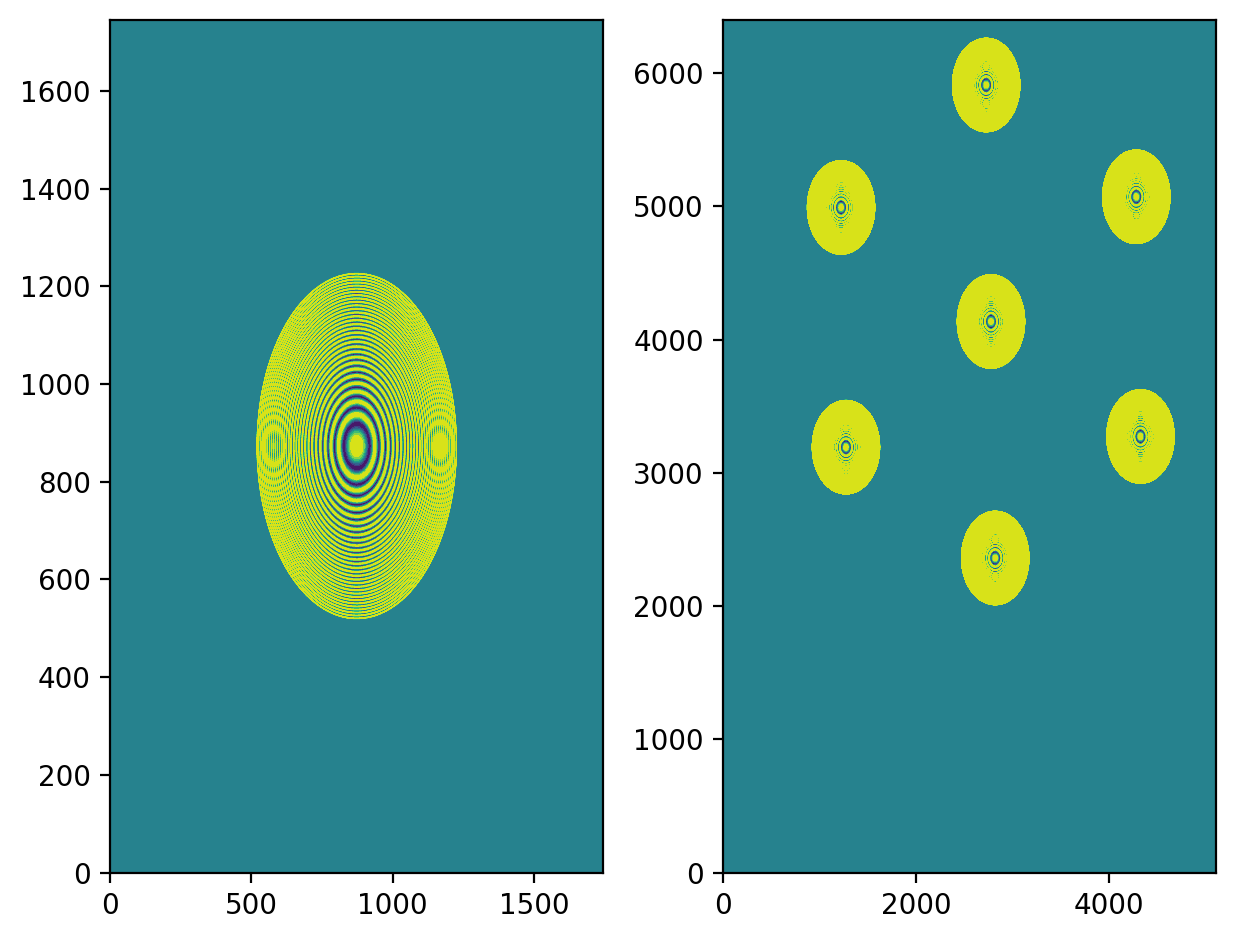

In [24]:
figure5 = plt.figure()
figure5.set_tight_layout(True)
ax1, ax2 = figure5.subplots(1,2)
ax1.contourf(single_lens_transmittance[0,0,:,:].cpu().numpy())
ax2.contourf(ulens_transmit[0,0,:,:].cpu().numpy())

# note that the plot looks like it's been flipped upside down, but it's just because of the way the image is plotted

resolution.yspace, resolution.xspace is the sensor spatial space! (defined as sensor_res * [-sensorsize/2, sensorsize/2] with steps = # of pixels in the direction (=sensor_size)
Nnum is number of pixels behind each lenslet
resolution.yMLspace, resolution.xMLspace is the MLA spatial space (defined as sensor_res * [-Nnum/2, Nnum/2], steps of 1
Sensor_size is calibration picture resolution in pixels
sensor_res is um/px 

In [25]:
# Properties that I do not know and I will just use the values in the code

LU0 = 500 # microns, physical length of the of sampled input at the NOP
N_calcPSF = 4095 # Resolution of the point spread function

Might be better to move everything into a pytorch tensor

In [26]:
len(perspectives[0,0,0,:]), len(perspectives[0,0,:,0])

(1747, 1747)

In [27]:
def psfCalc(fobj, k, NA, calibration_img, pixel_pitch, wavelength, n, depths):
    # Feed in depths as a list of depths
    
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Getting errors with MPS support
    device = torch.device("cpu")
    
    sensor_spatial = [int(len(calibration_img[:,0]) * pixel_pitch), int(len(calibration_img[0,:]) * pixel_pitch)]# sensor size (in micron) = pixel size (in micron/px) * sensor size (in px)
    sensor_size = [int(len(calibration_img[:,0])), int(len(calibration_img[0,:]))] # sensor size in pixels
    
    # fobj = objective focal length
    # k = wave number
    # NA = objective numerical aperture
    # sensor_size = size of the sensor in microns, calculated from the calibration image size and the pixel size, sensor size (in micron) = pixel size (in micron/px) * sensor size (in px)
    # d = lenslet pitch
    # n = refractive index
    # n_step = number of steps in the z direction
    
    # phase delay suffered by the rays is the optical path difference (WHy are we calculating this?)
    #if n != n_step:
        #theta_half = theta / 2
       # diff = (d / config[8]) * (n-n_step) * (1 + 2*n / n_step * np.sin(theta_half)^2 + 2*(n+n_step) * (n**2) / (n_step**3) * np.sin(theta_half)^4)
    #else:
       #diff = 0
        
    # Now we simulate the propagation of the rays to the sensor plane
    amp = 10 # Normalized amplitude of the rays
    mid = int((N_calcPSF+1)/2) # Where the delta function is located, N_calcPSF is always odd
    NOP_x = torch.linspace(-LU0/2, LU0/2, N_calcPSF, dtype = torch.float32).to(device) # x coordinates of the NOP plane
    NOP_y = NOP_x # y coordinates of the NOP plane, we assume the NOP is square
    x, y = torch.meshgrid(NOP_x, NOP_y, indexing = 'ij') # Meshgrid of the NOP
    
    psf_sensor = torch.zeros(len(depths), sensor_size[0], sensor_size[1]).to(device) # Initialize the PSF with the sensor size
    
    # We note that the PSF is shift-invariant, so we can calculate the PSF at the origin
    for i in range(len(depths)):
        if depths[i] == 0:
            depths[i] = 1e-8 # To avoid division by 0
        
        r = torch.sqrt(x**2 + y**2 + depths[i]**2) / n # Distance from the origin to the sensor plane
        
        if depths[i] < 0:
            r = -r # To propogate to the lens
        
        #[U1, LU1] = FLFM_lensProp(U0, LU0, Camera.WaveLength, Camera.fobj);
    
        U0 = -1 * torch.tensor([1j], dtype = torch.complex64, device=device) * amp * k * torch.exp(torch.tensor([1j], dtype = torch.complex64,device = device)*k*r) / (2 * torch.pi * r) # The PSF at the origin
    
        source_sample_rate = LU0 / len(U0) # Sampling rate of the input field
        
        U1 = (-torch.tensor([1j], dtype = torch.complex64,device=device)*torch.exp(torch.tensor([1j], dtype = torch.complex64,device = device)*k*fobj)/wavelength/fobj) * torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(U0))) * (source_sample_rate**2) # Propogate to the sensor plane, with a scaling factor to account for the sampling
        LU1 = wavelength * fobj# Physical length of the sampled input field at the sensor plane
        
        # Back Apeture Propogation
        circle = lambda a, b, r: (a**2 + b**2) < r**2 # Circle function
        dobj = 2 * NA * fobj # Diameter of the objective
        U1 = U1 * circle(x/LU0*LU1, y/LU0*LU1, dobj/2) # Multiply the PSF by the circle mask
        
        M_relay = f2 / f1 # Relay magnification
        
        cut = [round(sensor_spatial[0] * (N_calcPSF + 1) / (2 * (M_relay * LU1))), round(sensor_spatial[1] * (N_calcPSF + 1) / (2 * M_relay * LU1))]

        psf = U1[mid - cut[0]: mid + cut[0], mid - cut[1]: mid + cut[1]].unsqueeze(0).unsqueeze(0) # Cut the PSF to the correct size
        psf_sensor[i,:,:] = transforms.Resize(size = sensor_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(psf)[0,0,:,:] # Resize the PSF to the sensor size
    
    return psf_sensor

In [28]:
depths = torch.linspace(-100, 100, 20) # Depths in microns, 10 microns is the increment between depths
gpu_psfstack = psfCalc(fobj, camera_params[1], NA, img, pixel_size, wavelength, refractive_index, depths) # The PSF stack in the GPU; MPS is apple metal performance shaders; need to do it other wise my kernel WILL crash
psfStack = gpu_psfstack.cpu()

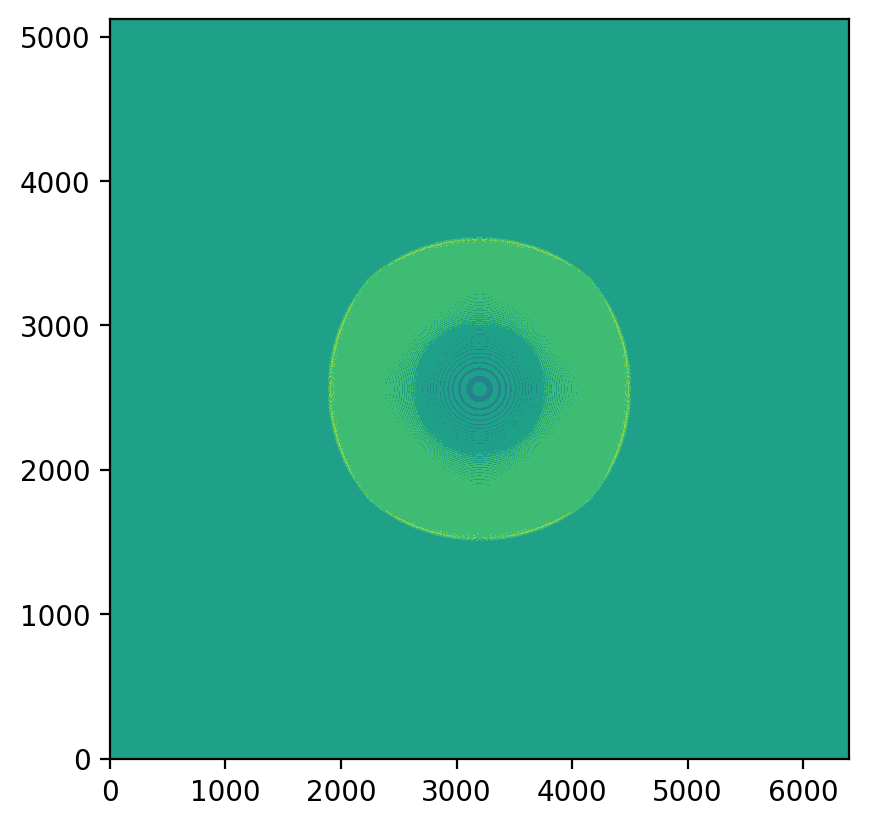

In [29]:
# Plotting the PSF
figure5 = plt.figure()
#figure5.set_tight_layout(True)
# make a 3d plot of the PSF with the depths as the z-axis
ax = figure5.add_subplot(111)
ax.set_aspect(len(psfStack[0,0,:])/len(psfStack[0,:,0]))
ax.contourf(psfStack[0,:,:].numpy())

function f1 = prop2Sensor(f0, sensorRes, z, lambda, idealSampling)

else
    %% Original Sampling: compute the Transfer Function H
    Nx = size(f0,1);
    Ny = size(f0,2);
    k = 2*pi/lambda;

    % spacial frequencies in x and y direction
    du = 1./(Nx*single(sensorRes(1)));
    dv = 1./(Ny*single(sensorRes(2)));
    u = [0:ceil(Nx/2)-1 ceil(-Nx/2):-1]*du; 
    v = [0:ceil(Ny/2)-1 ceil(-Ny/2):-1]*dv; 

    % transfer function for Rayleigh diffraction integral
    H = exp(1i*sqrt(1-lambda^2*(repmat(u',1,length(v)).^2+repmat(v,length(u),1).^2))*z*k); 

    % final Lightfield PSF -> sensor image
    f1 = exp(1i*k*z)*(ifft2(fft2((f0)) .* H ));
end 

In [30]:
def LFPSF(psfStack, calibration_image, pixel_size, mla2sensor, wavelength, ulens_transmittance, depths):
    
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    device = torch.device("cpu")
    
    ulens_transmittance = ulens_transmittance.to(device)
    
    forward = torch.zeros(len(calibration_image[:,0]), len(calibration_image[0,:]), len(psfStack[:,0,0]), dtype = torch.complex64, device = device)
    backward = torch.zeros(len(calibration_image[:,0]), len(calibration_image[0,:]), len(depths), dtype = torch.complex64, device = device)
    
    Nx = len(psfStack[0,:,0])
    Ny = len(psfStack[0,0,:])
    k = 2 * torch.pi / wavelength
        
    du = torch.div(1, (Nx * pixel_size))
    dv = torch.div(1, (Ny * pixel_size))
    u = torch.concatenate((torch.arange(0, np.ceil(Nx/2)), torch.arange(-np.ceil(Nx/2), 0))).to(device) * du
    v = torch.concatenate((torch.arange(0, np.ceil(Ny/2)), torch.arange(-np.ceil(Ny/2), 0))).to(device) * dv
        
    H = torch.exp(torch.tensor(1j, dtype=torch.complex64, device=device) * torch.sqrt(1 - (wavelength**2) * mla2sensor * k * (torch.pow(torch.tile(torch.transpose(u.reshape(1,-1),0,1), (1,len(v))), 2).to(device) + torch.pow(torch.tile(v, (len(u),1)), 2))).to(device)) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    
    for i in range(len(psfStack[:,0,0])):
        psfMLA = torch.mul(psfStack[i,:,:], torch.permute(ulens_transmittance[0,0,:,:].squeeze(0), (1,0))) # Multiply the PSF by the transmittance function
        forward[:,:,i] = torch.pow(torch.exp(torch.tensor(k * mla2sensor * 1j)) * torch.fft.ifft2(torch.nan_to_num(torch.mul(torch.fft.fft2(psfMLA),H))),2)
        forward[:,:,i] = forward[:,:,i] / torch.sum(forward[:,:,i]) # Normalize the PSF
        
    for j in range(len(depths)):
        backward[:,:,j] = torch.rot90(forward[:,:,j], 2) # Rotate the PSF 180 degrees and normalize it
    
    return forward, backward

In [31]:
forward_test, backward_test = LFPSF(psfStack, img, pixel_size, mla2sensor, wavelength, ulens_transmit, depths)

In [32]:
torch.save(forward_test, r'/Users/halensolomon/Code/FLFM_local/testing/forward_test.pt')
torch.save(backward_test, r'/Users/halensolomon/Code/FLFM_local/testing/backward_test.pt')

/var/folders/tw/r7vzypfs02q87460_njpb5wm0000gn/T/ipykernel_43859/1406129538.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  ax1.contour(forward_test[:,:,i].cpu().numpy().astype(np.float16), cmap = 'gray')
/var/folders/tw/r7vzypfs02q87460_njpb5wm0000gn/T/ipykernel_43859/1406129538.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  ax2.contour(backward_test[:,:,i].cpu().numpy().astype(np.float16), cmap = 'gray')


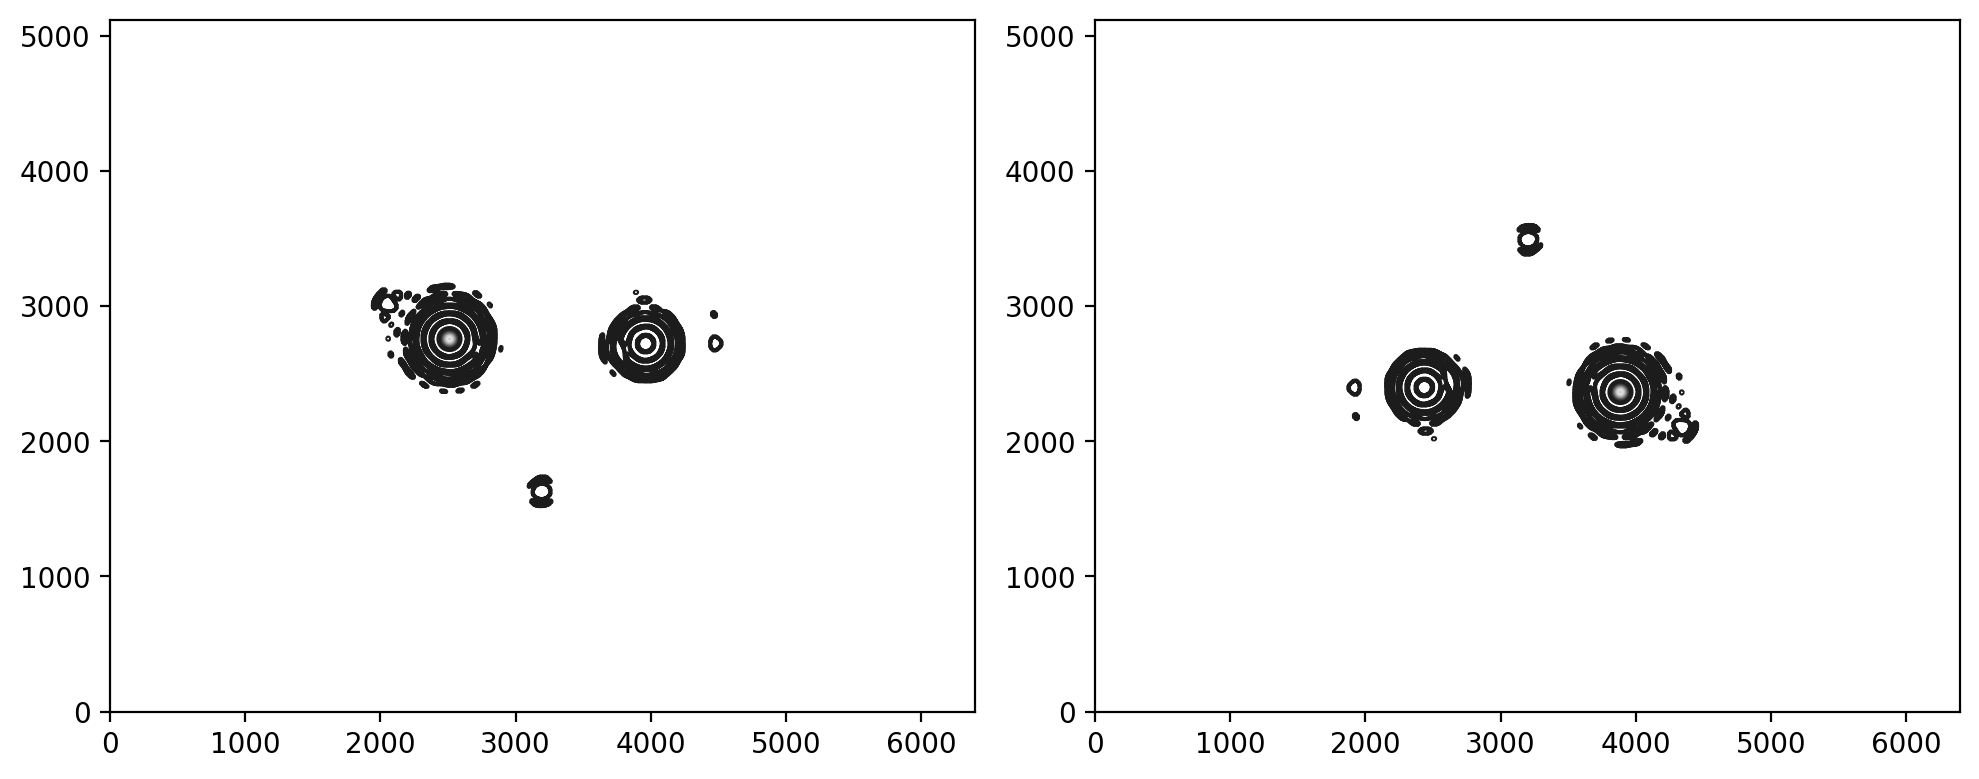

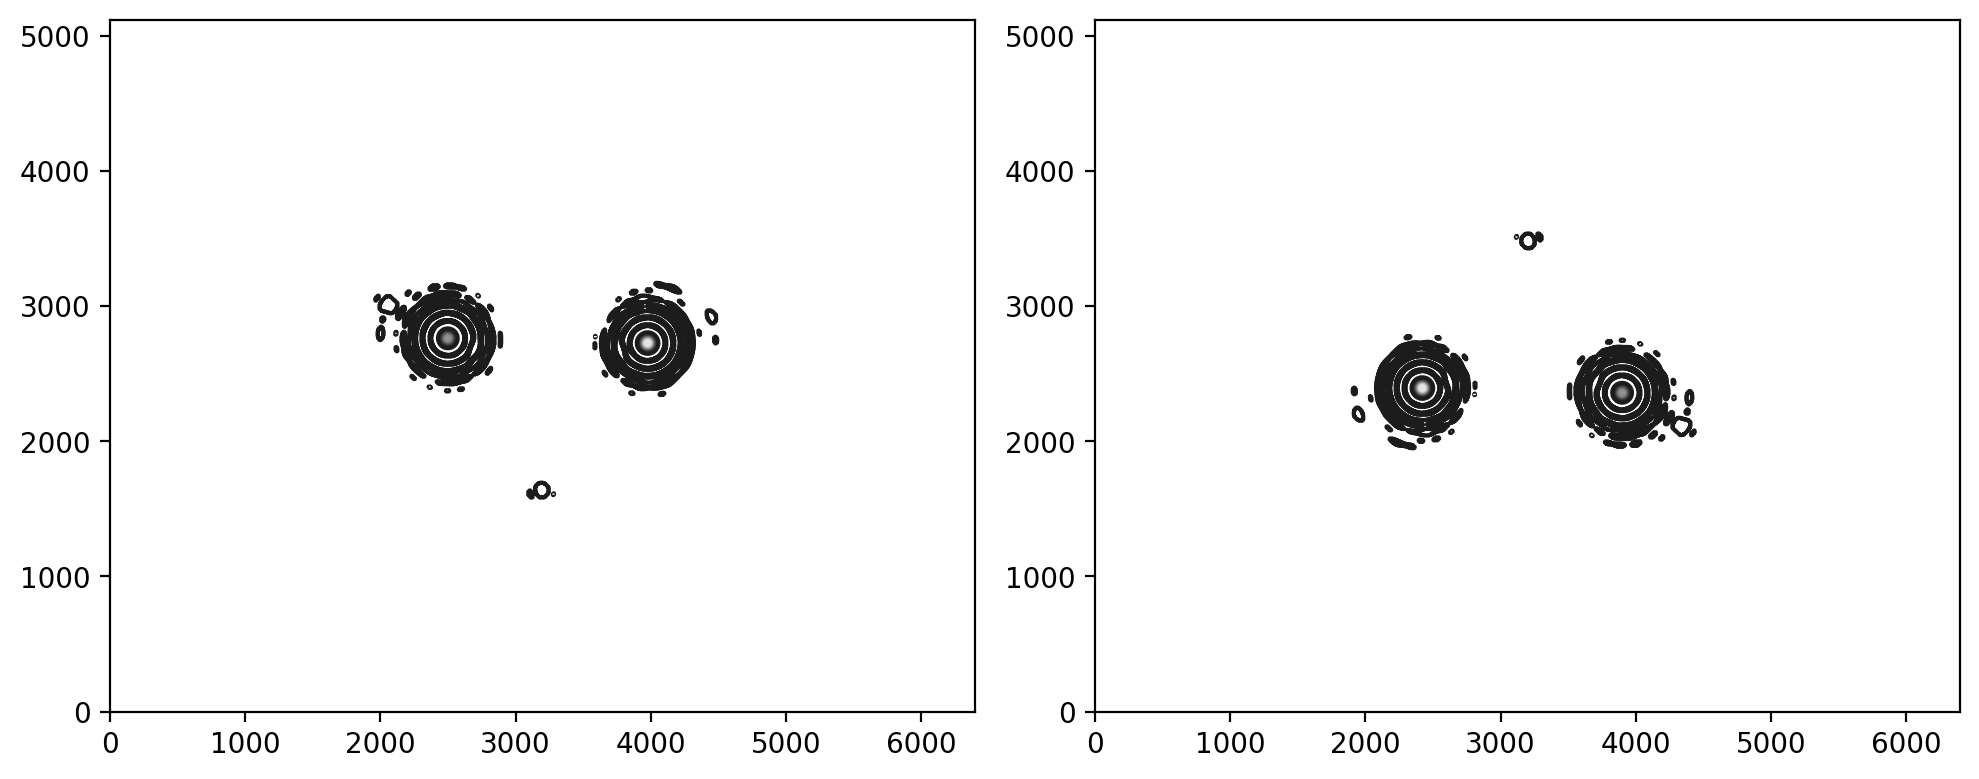

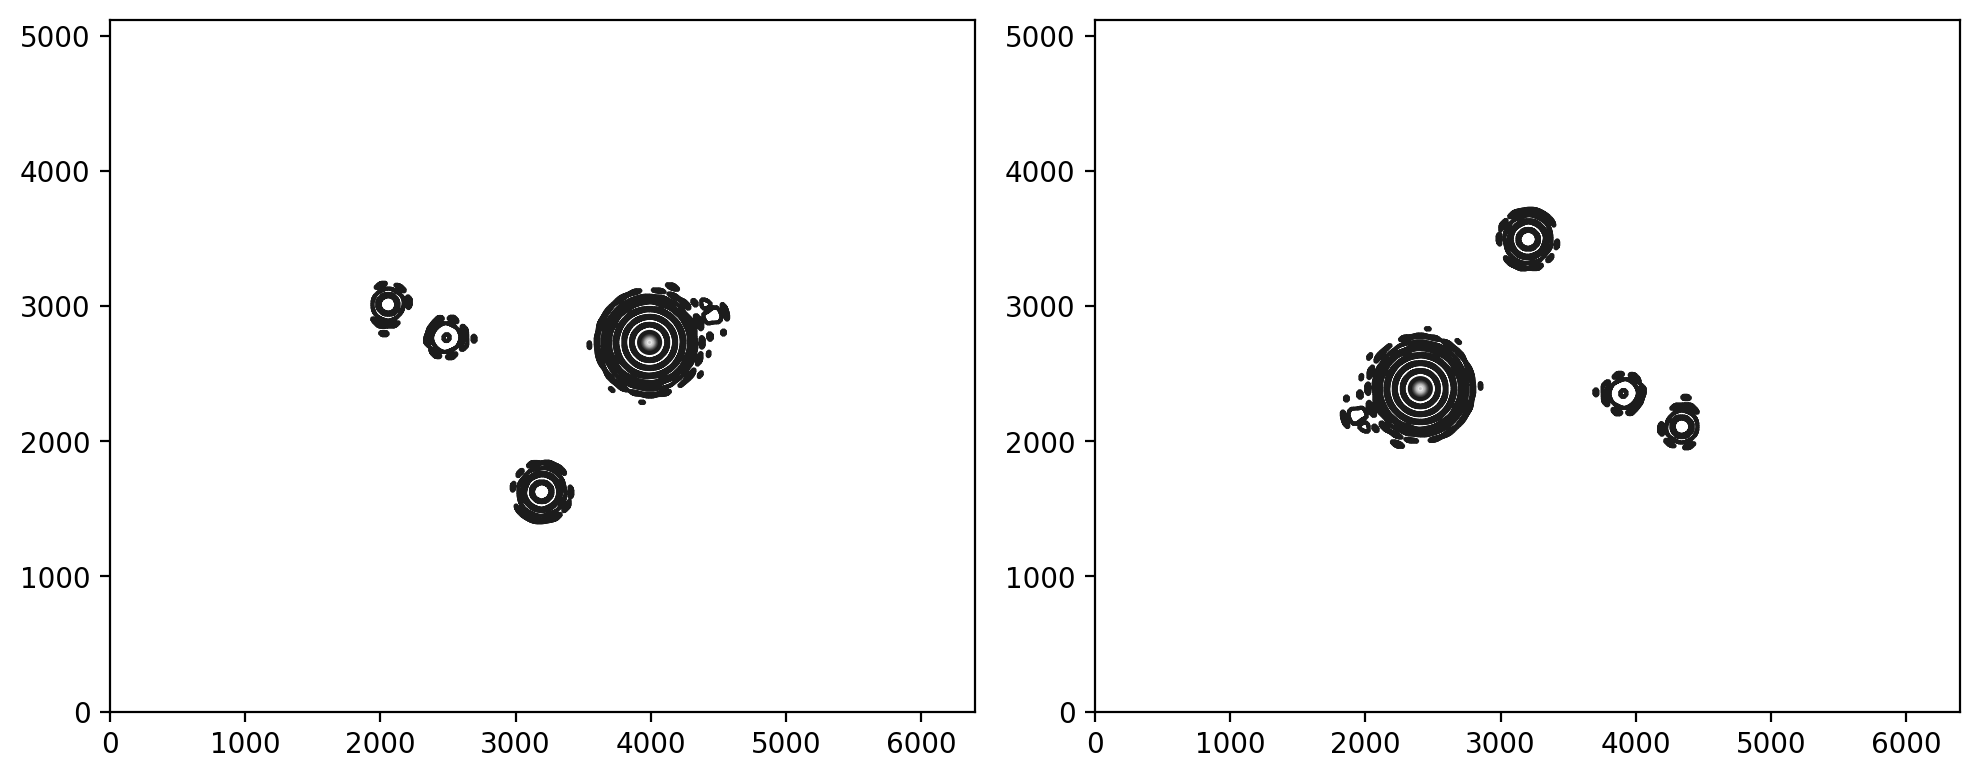

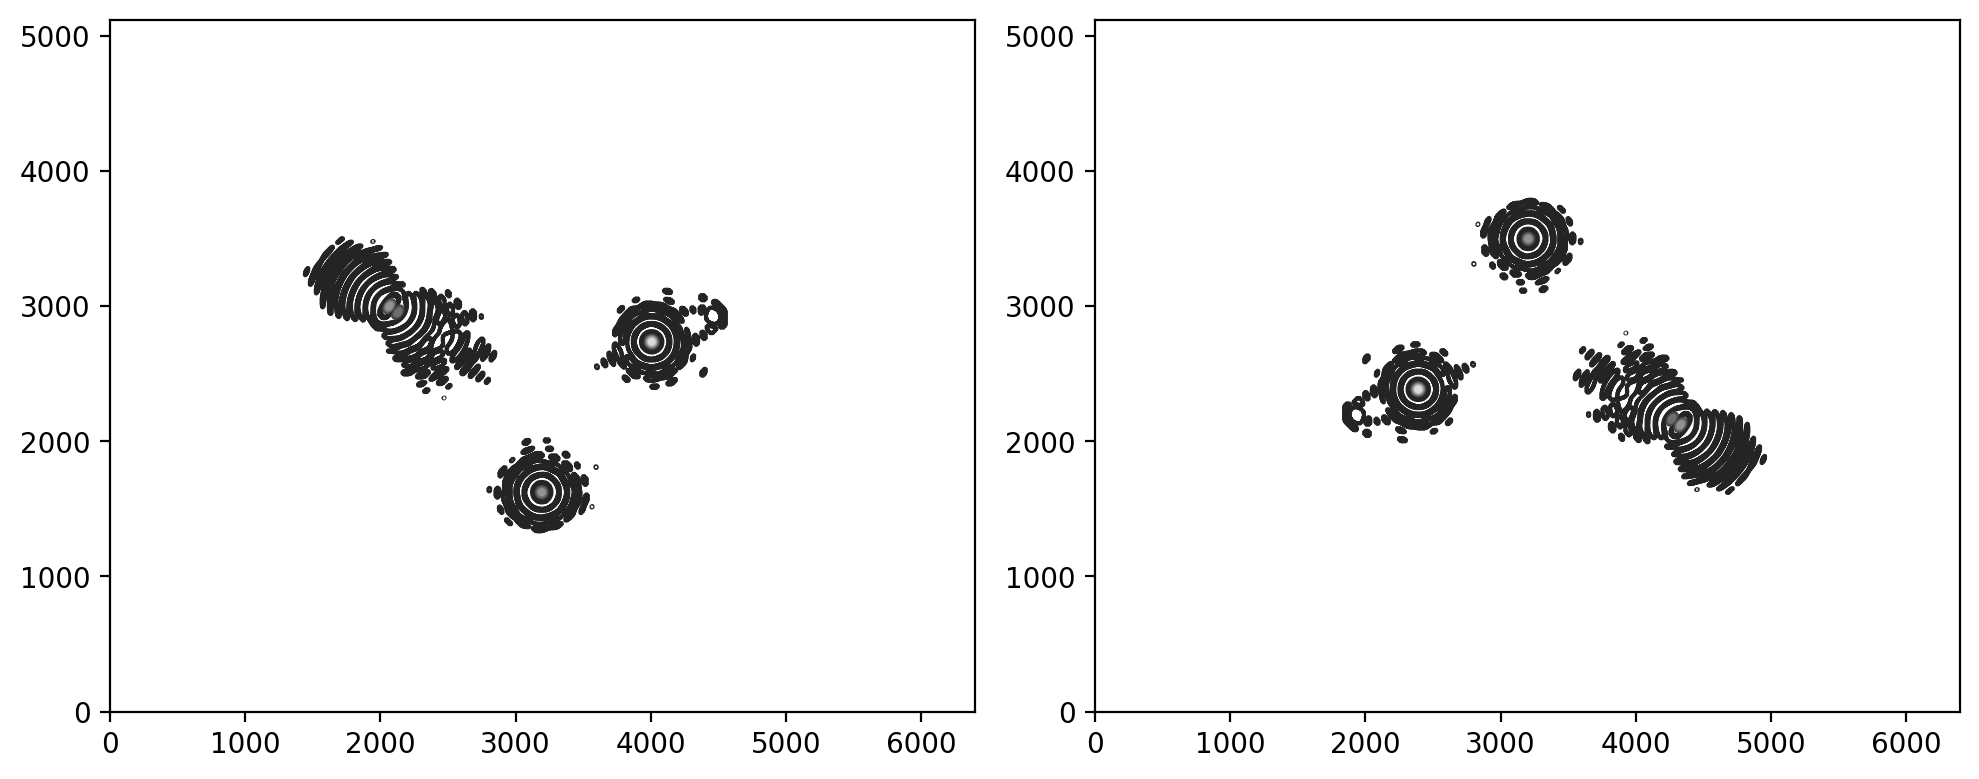

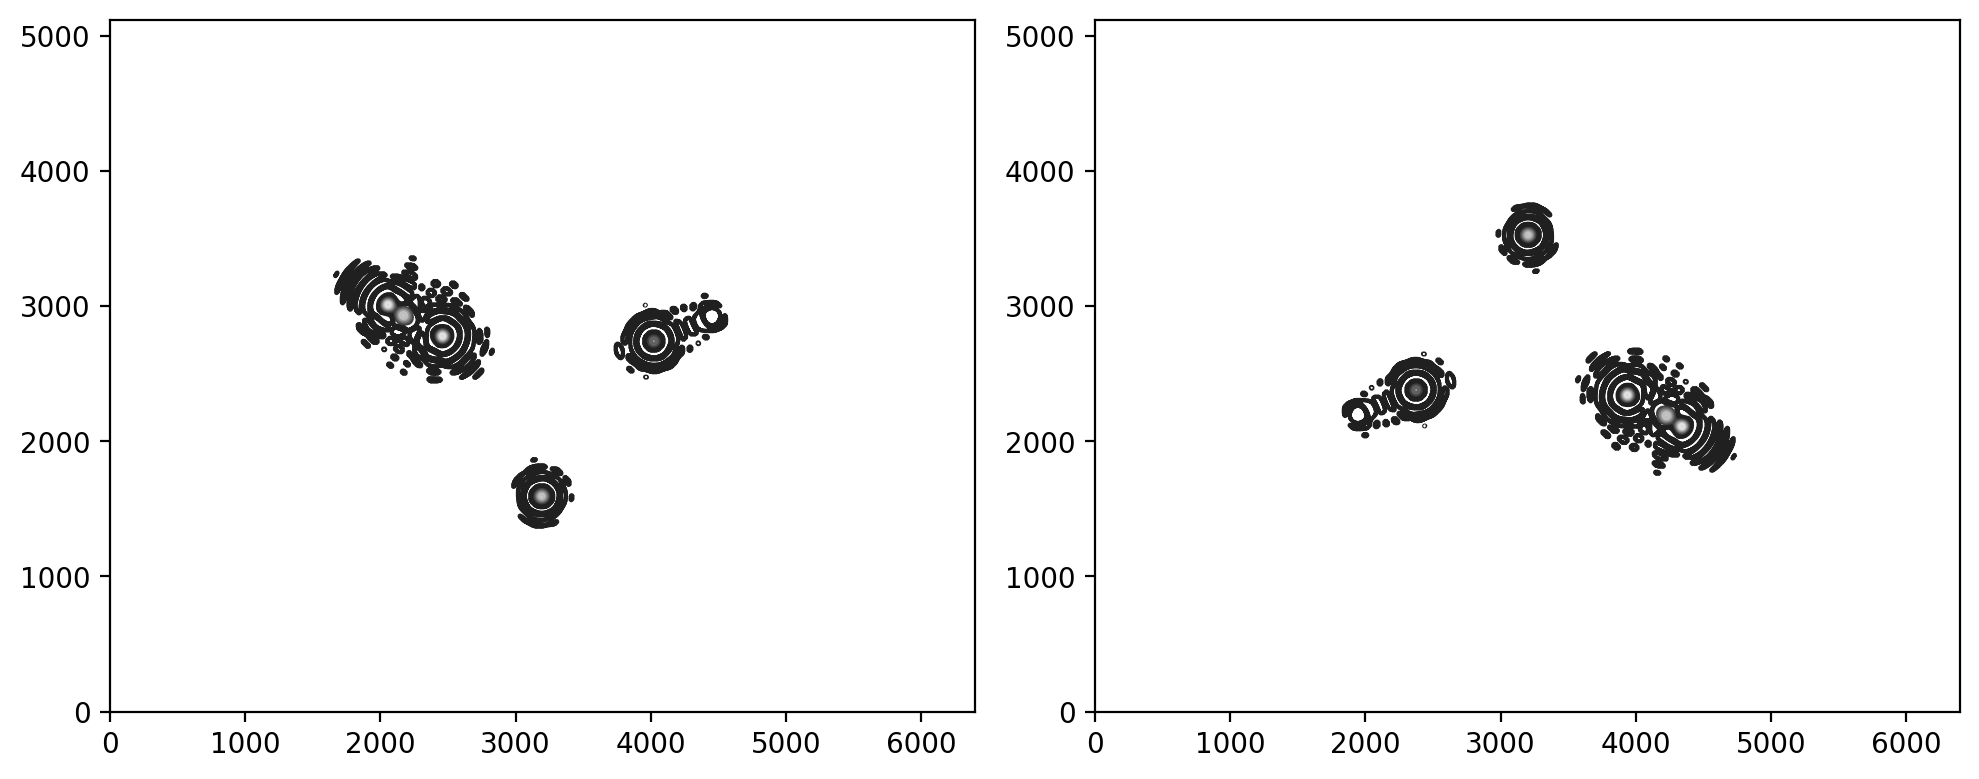

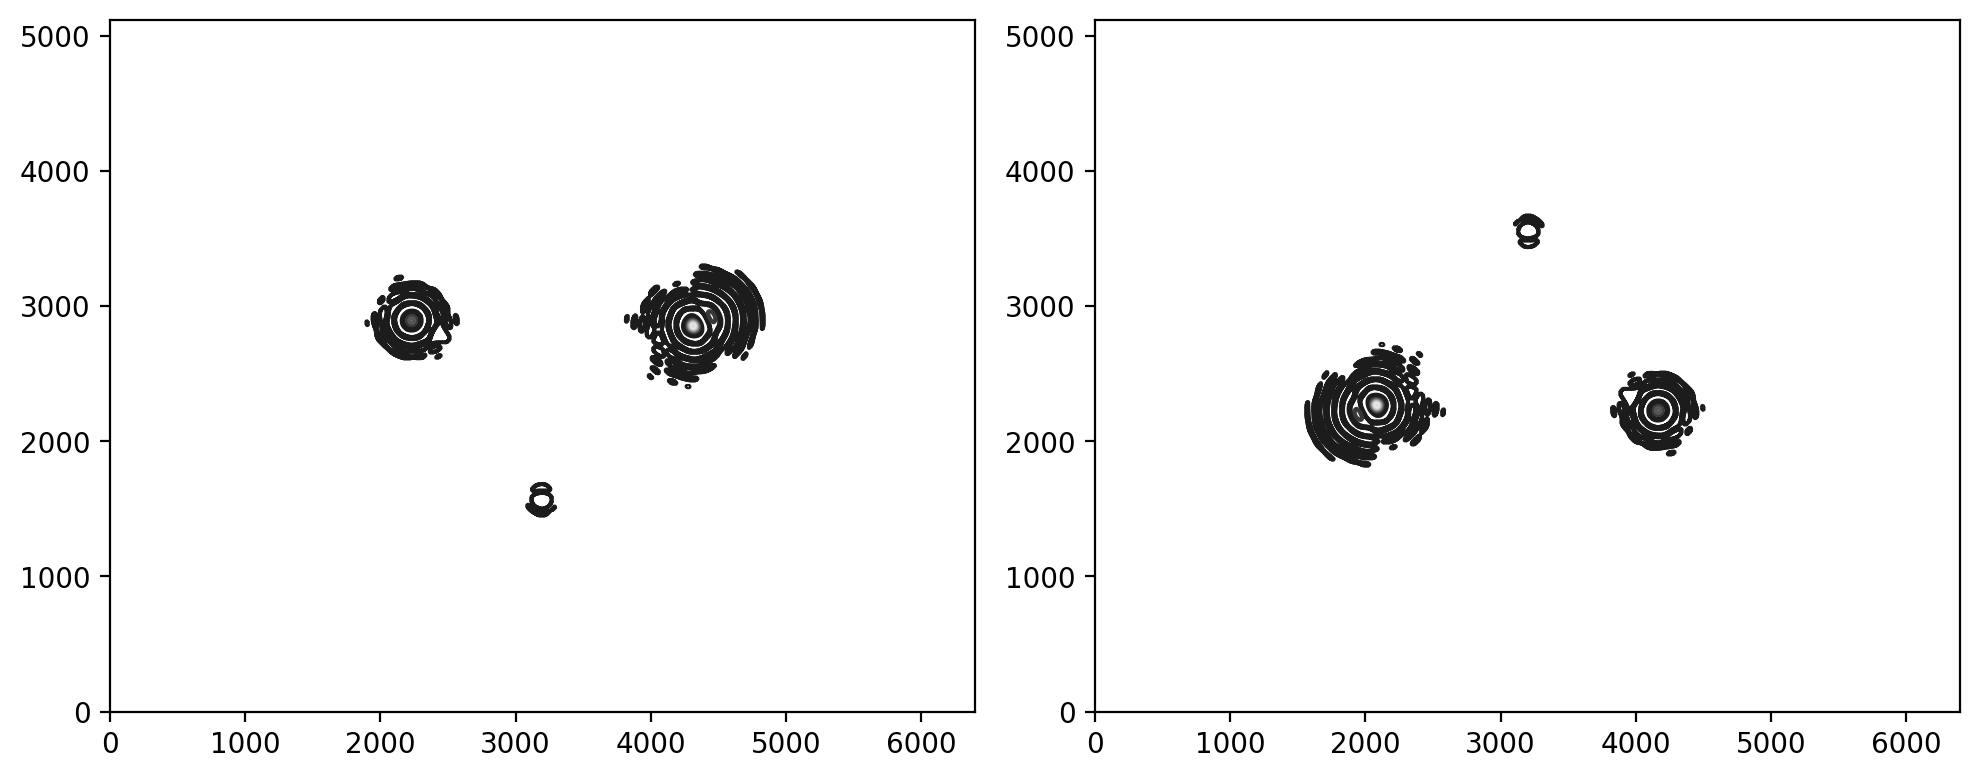

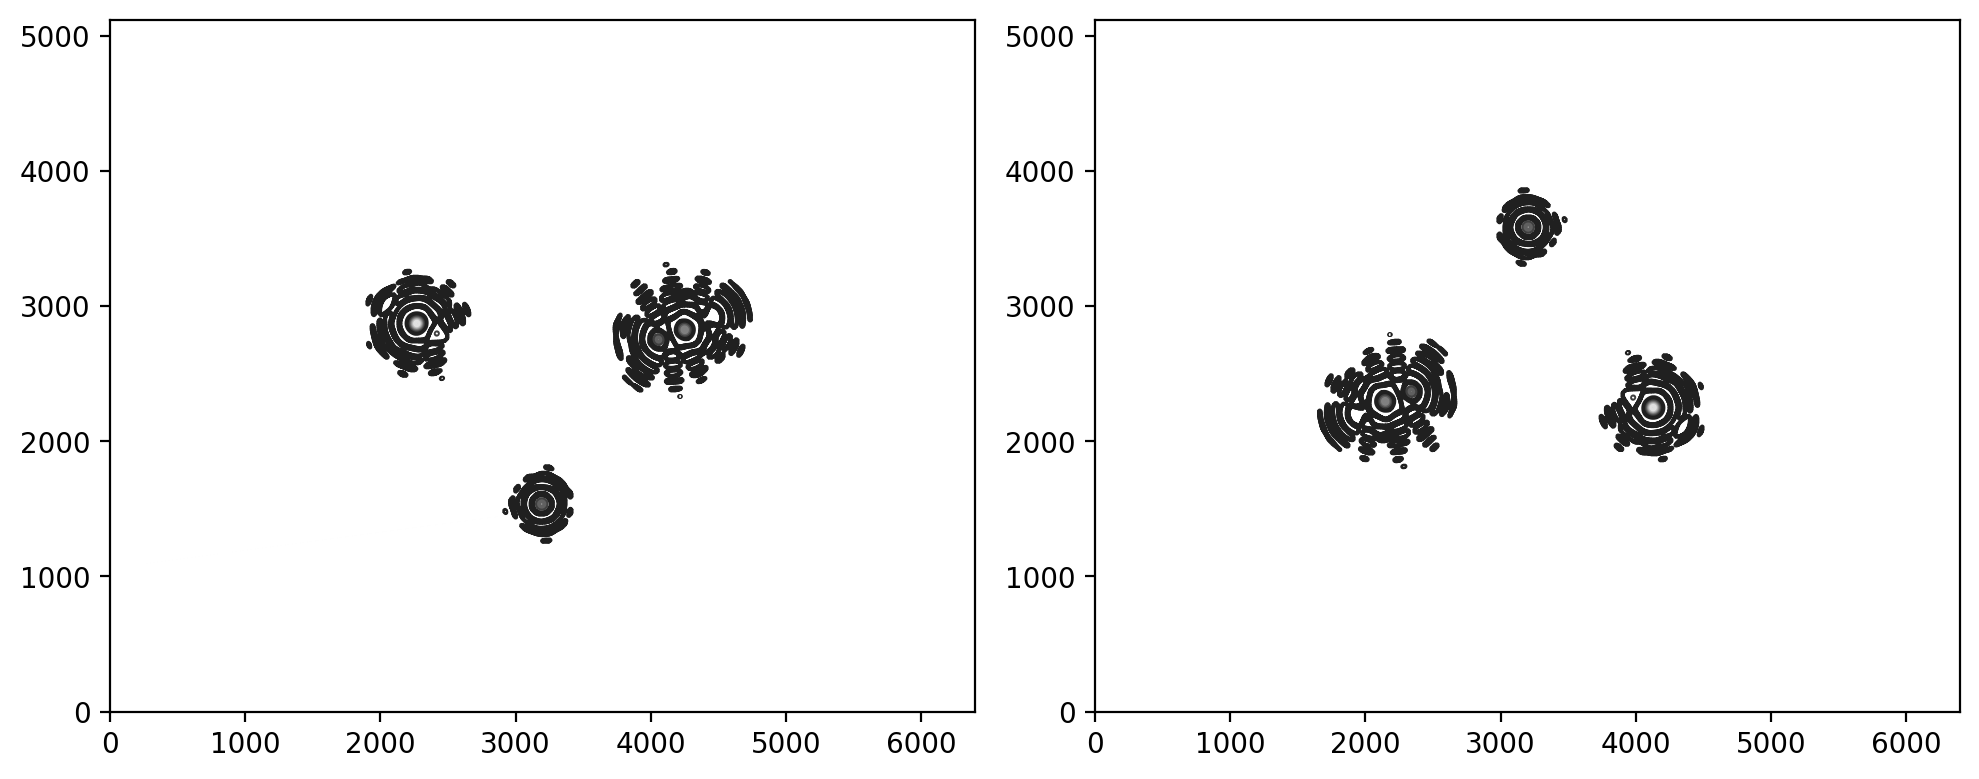

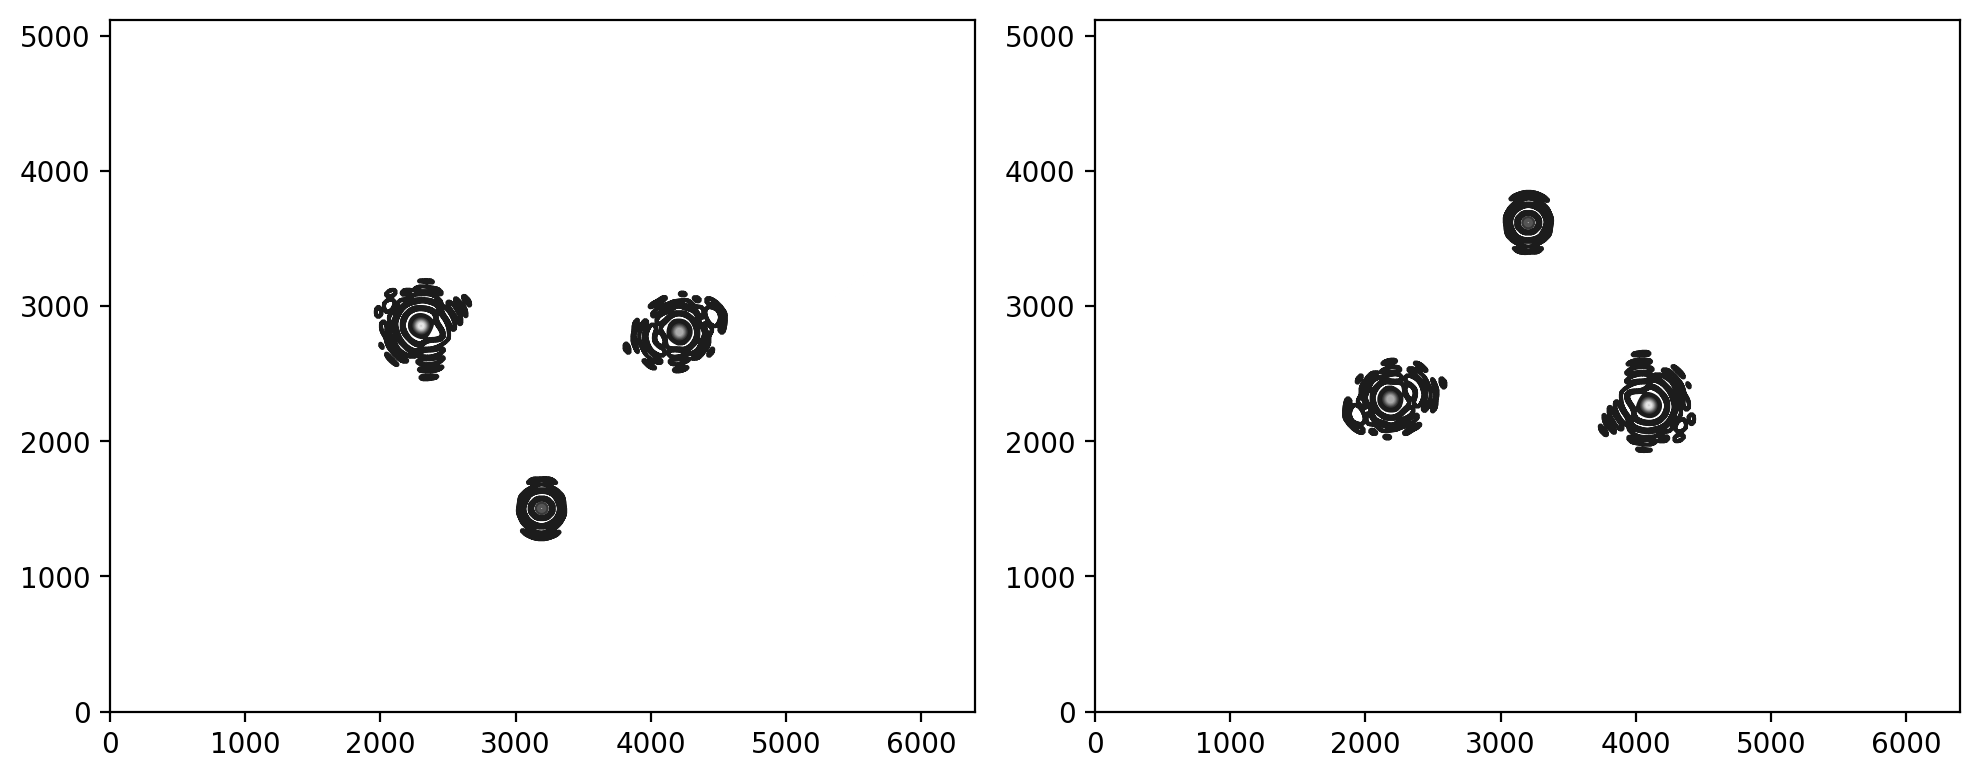

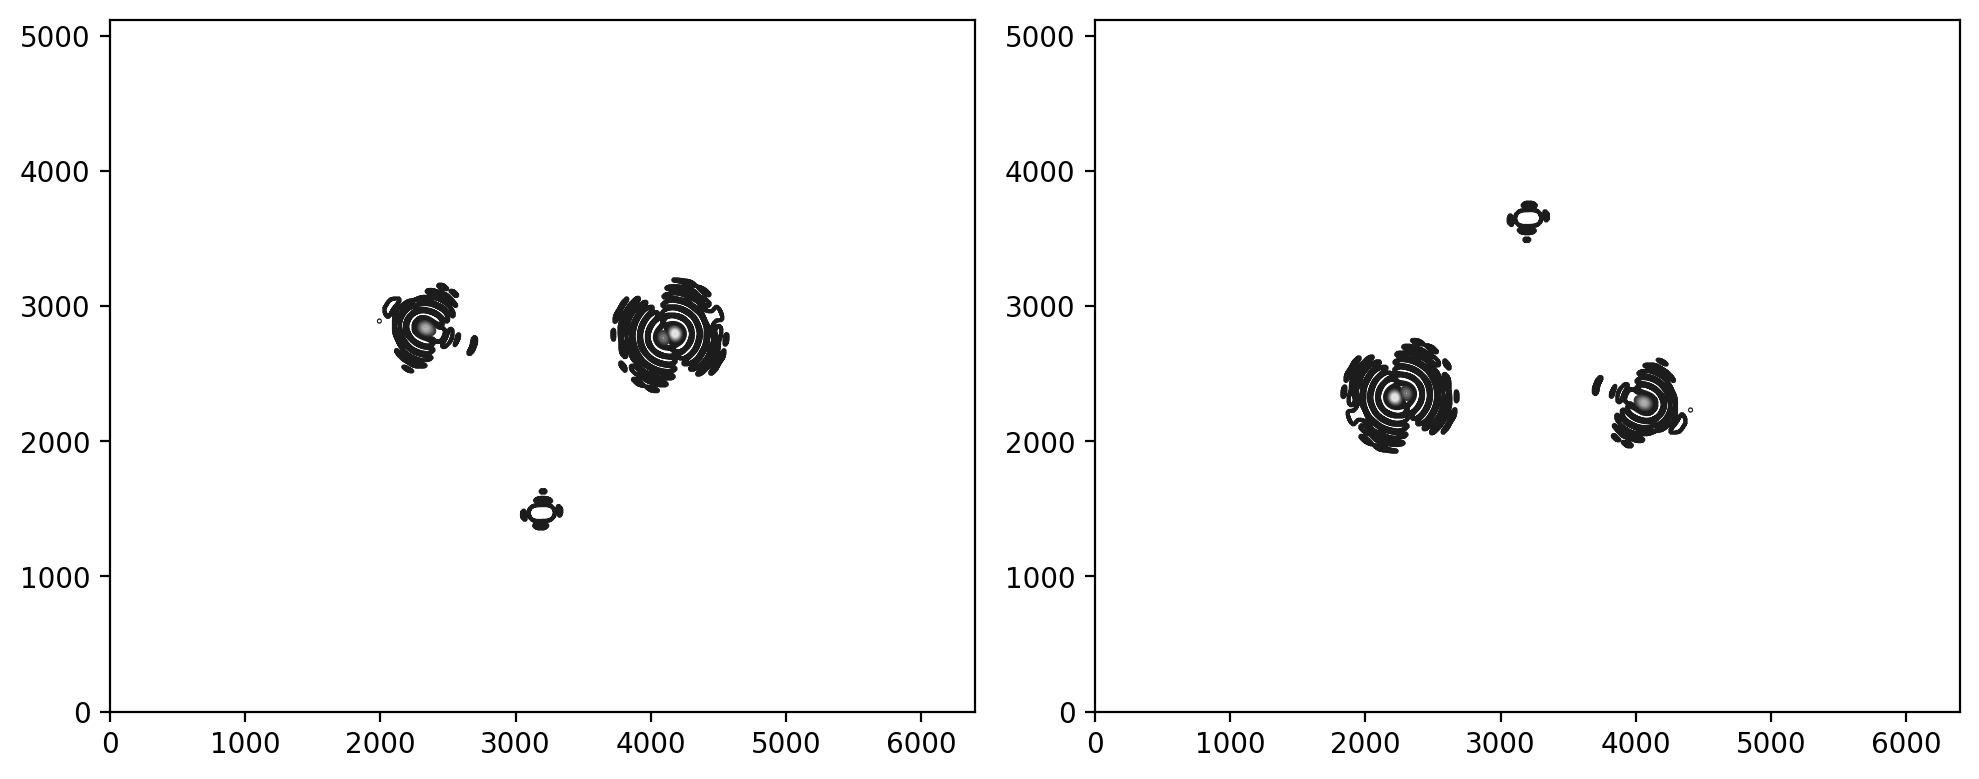

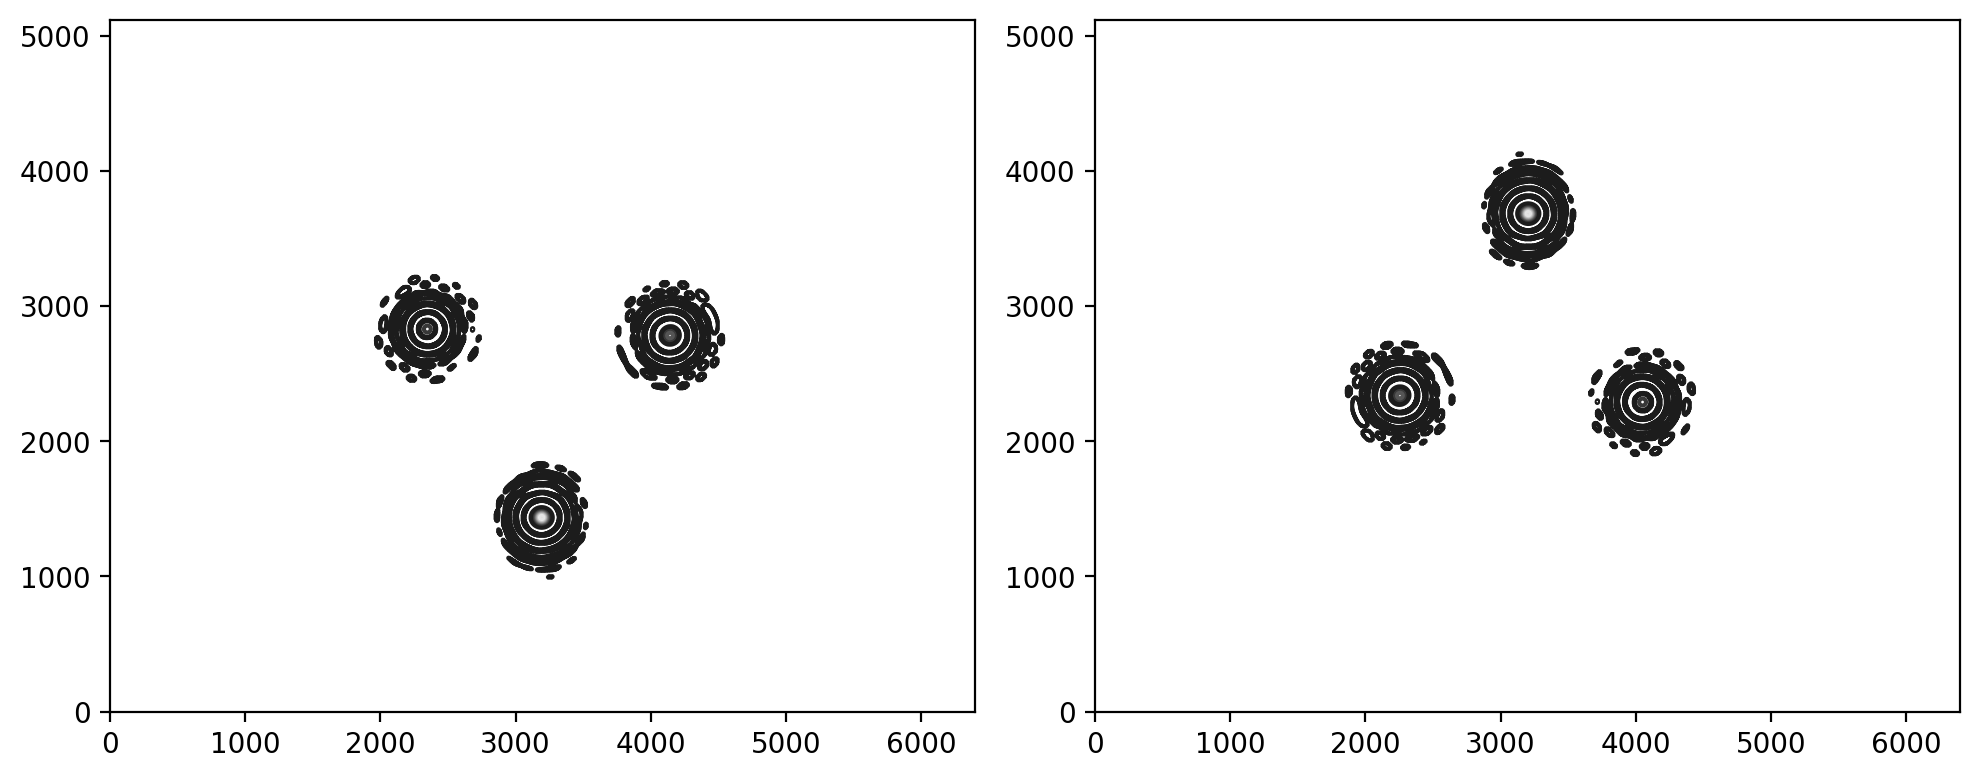

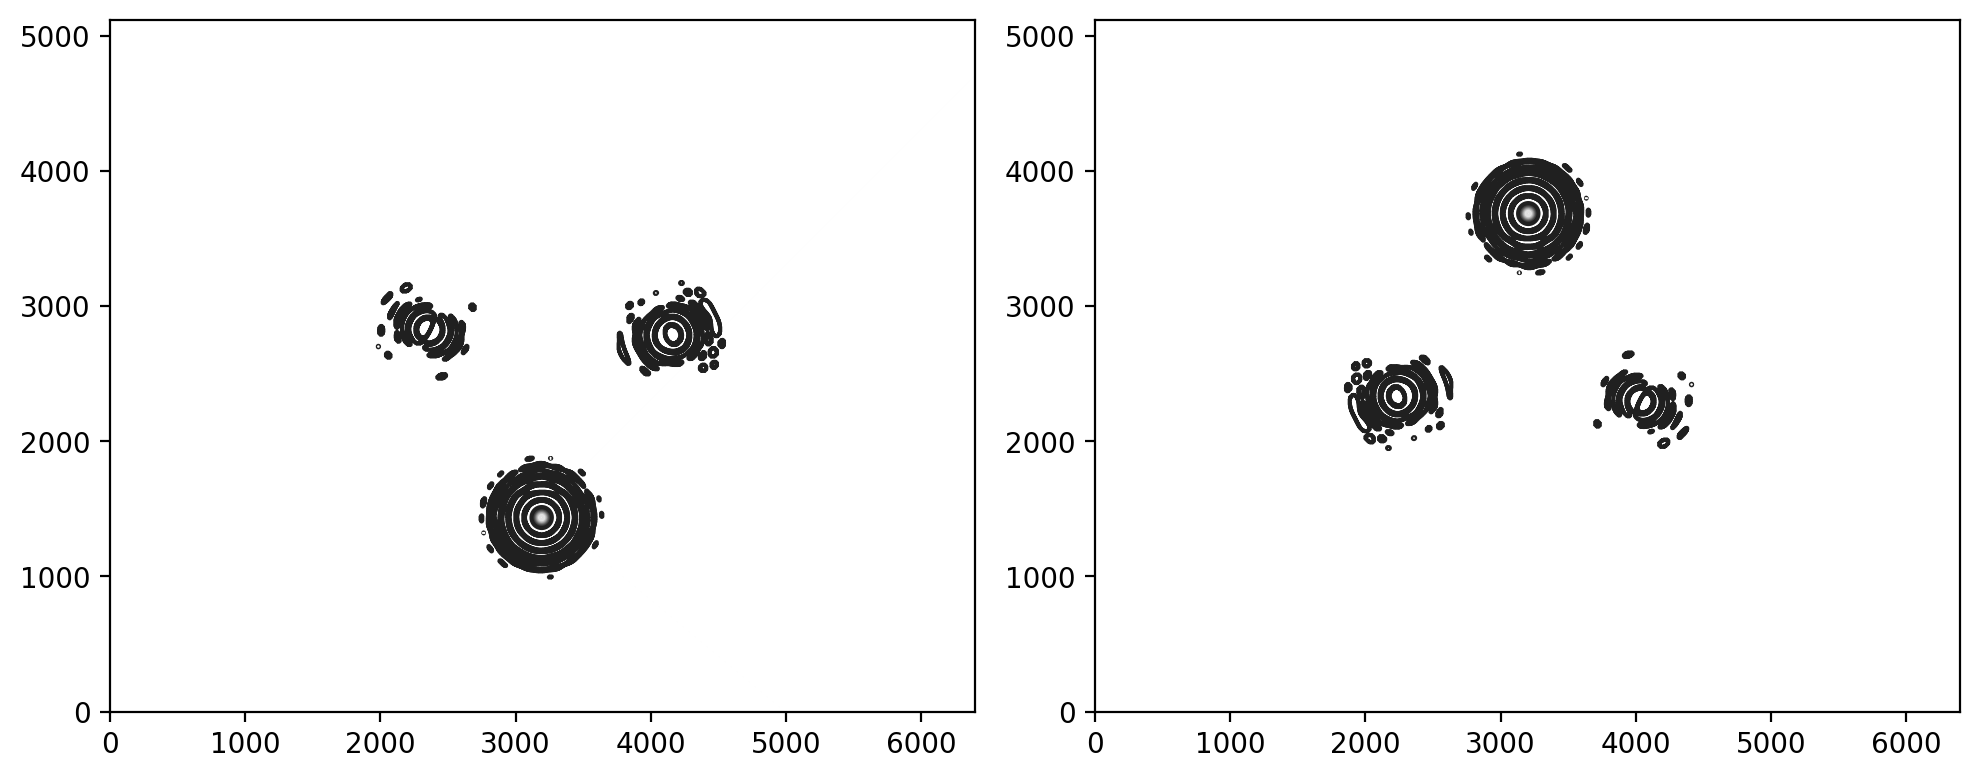

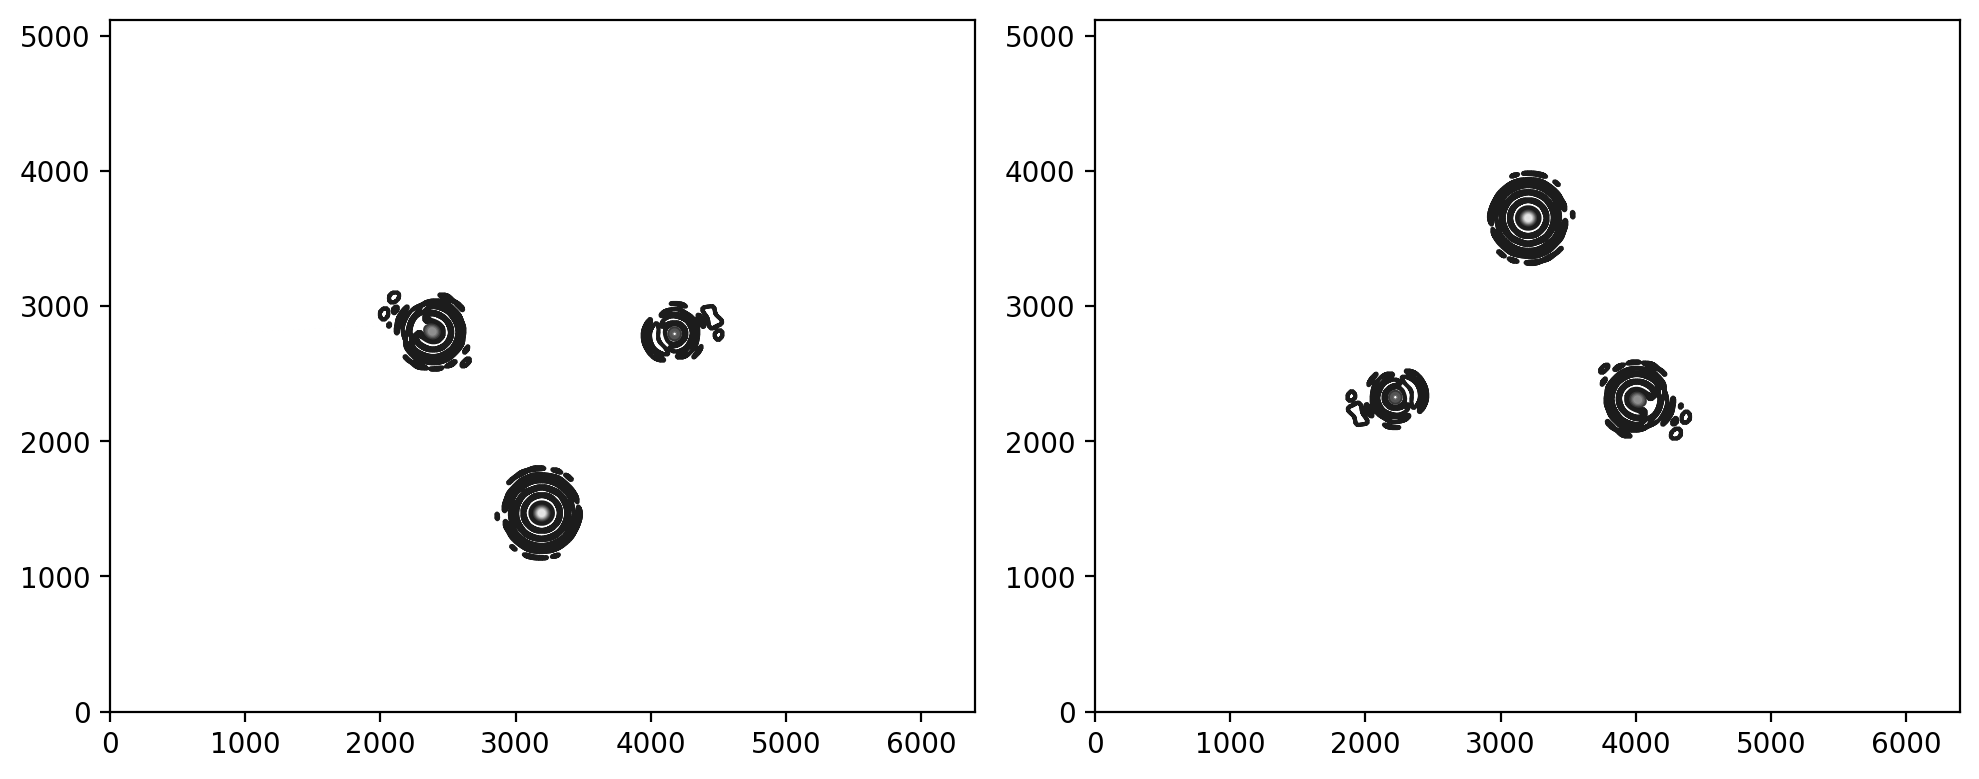

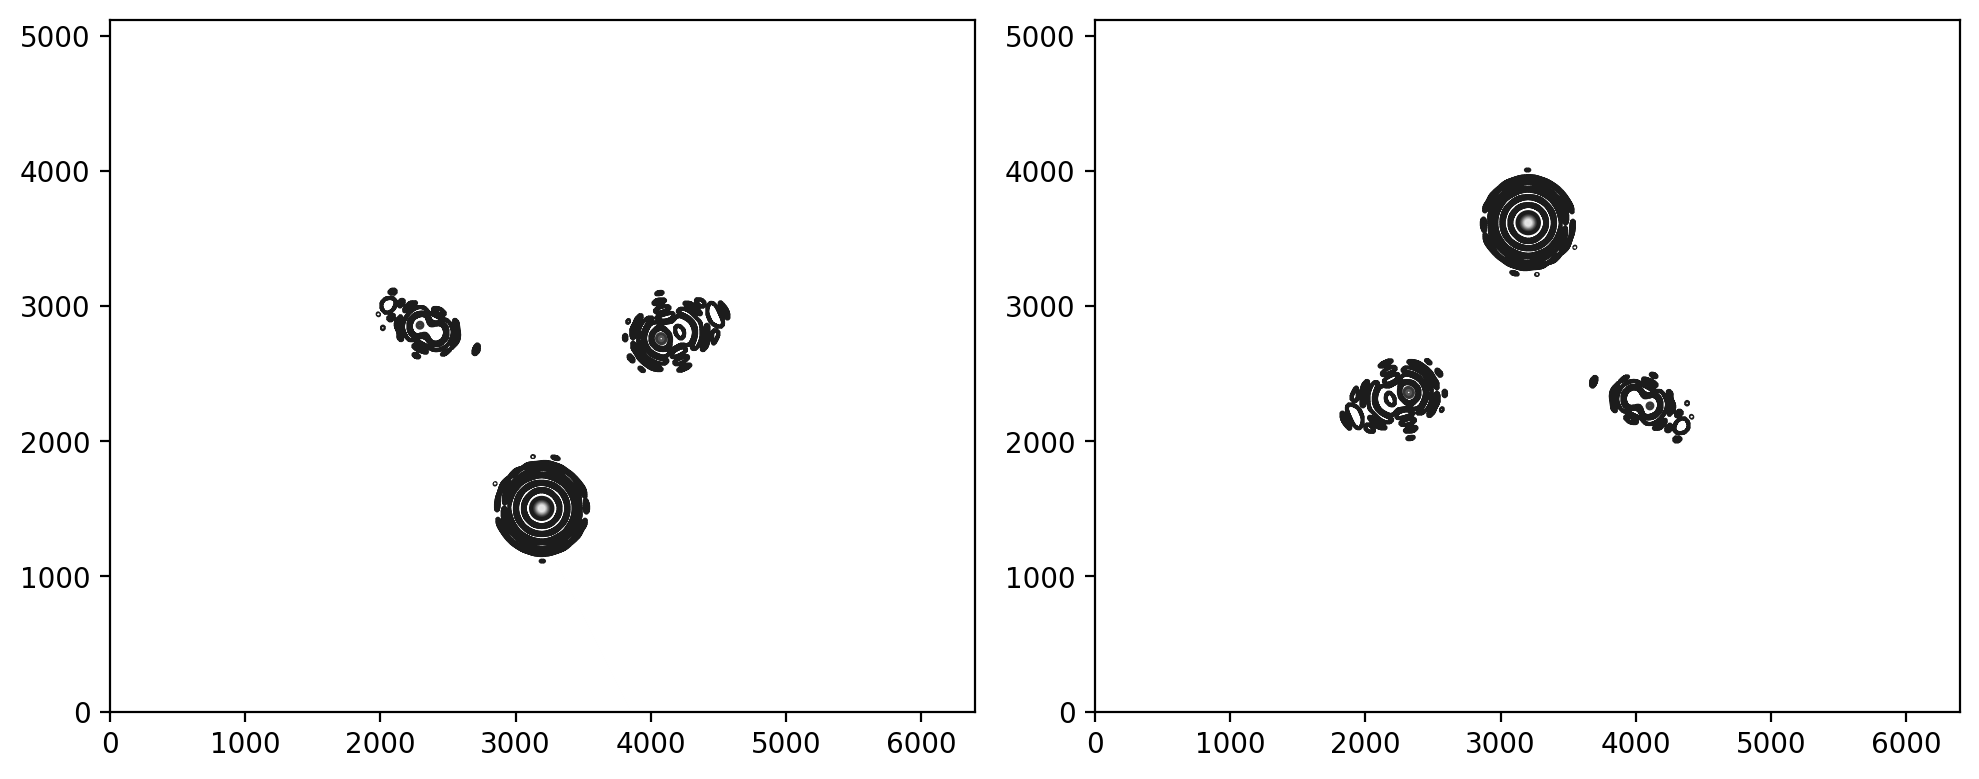

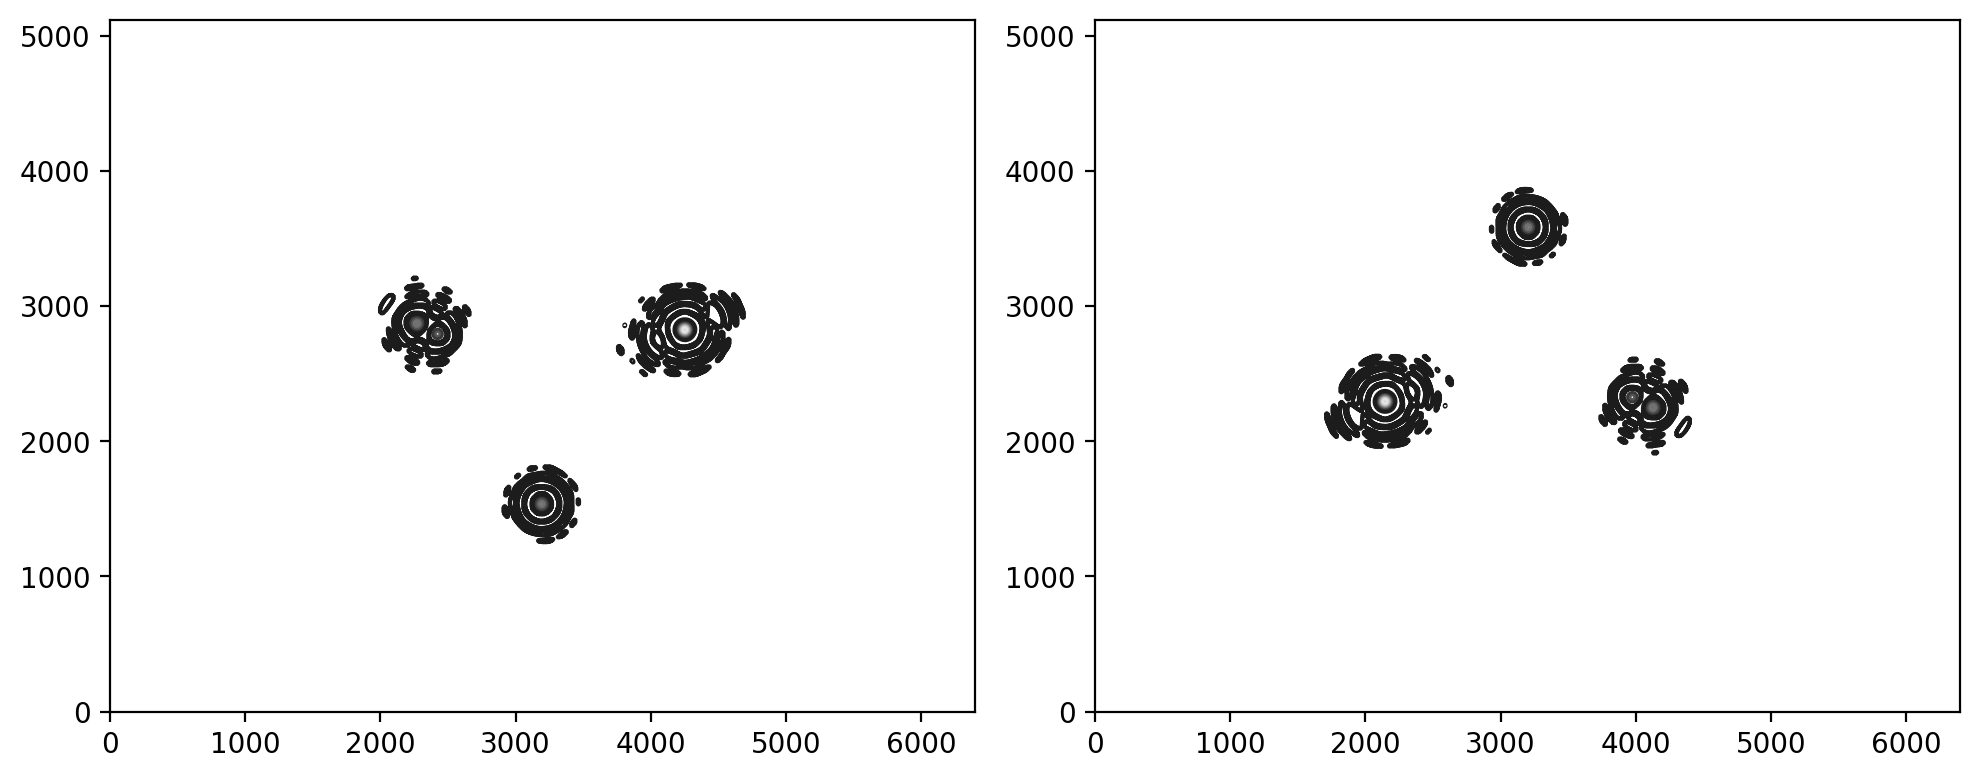

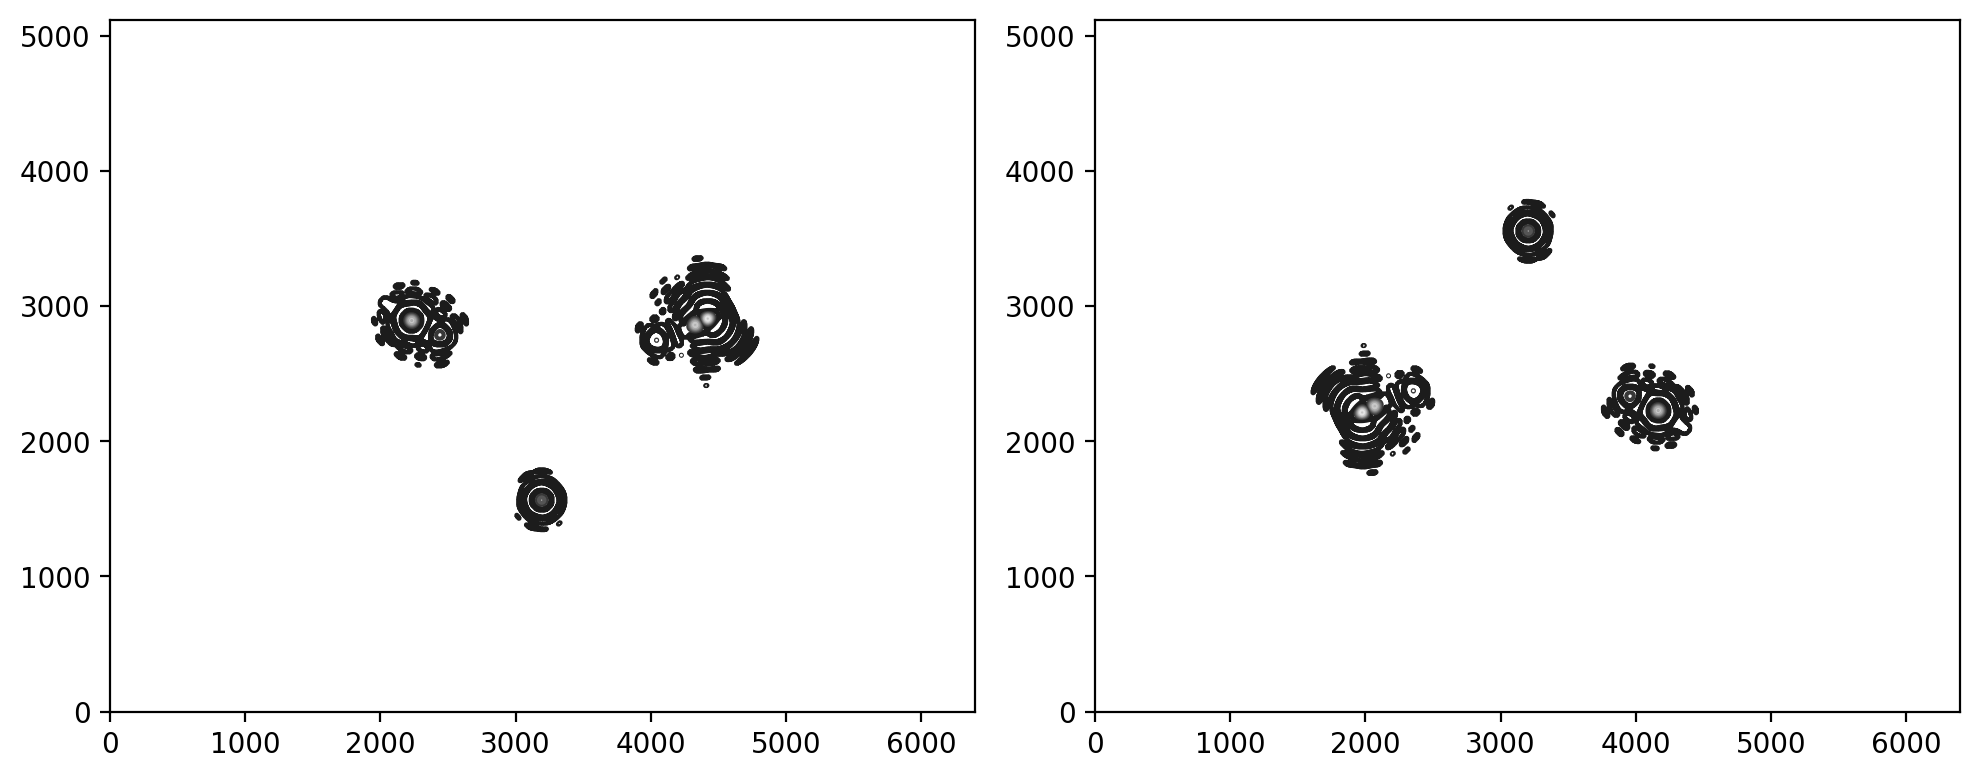

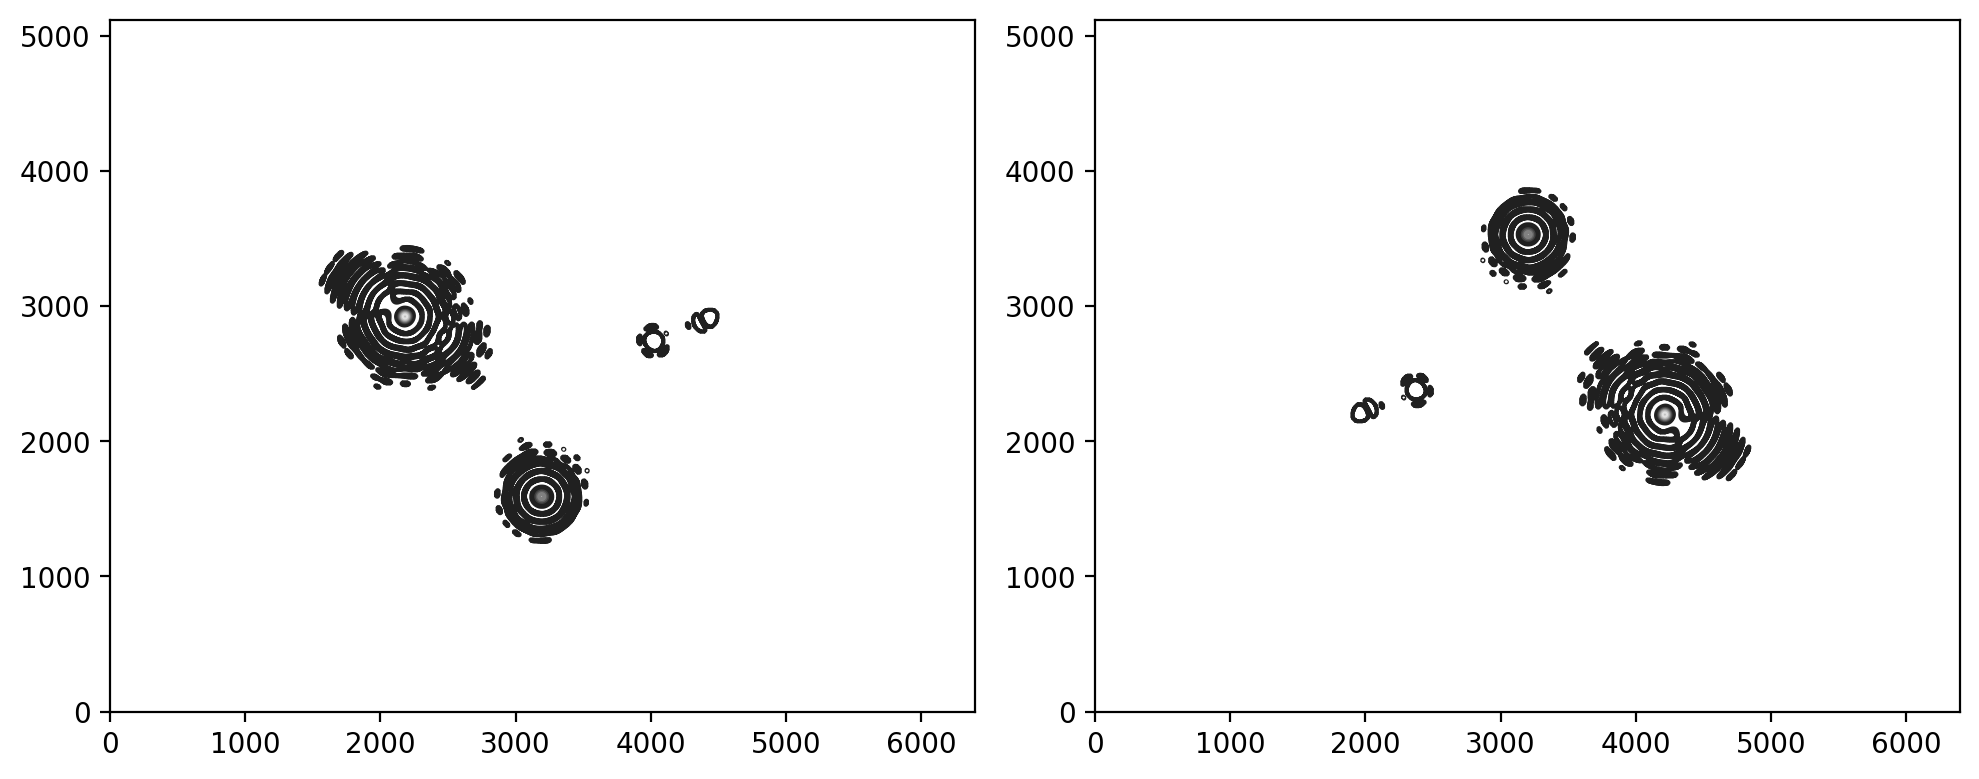

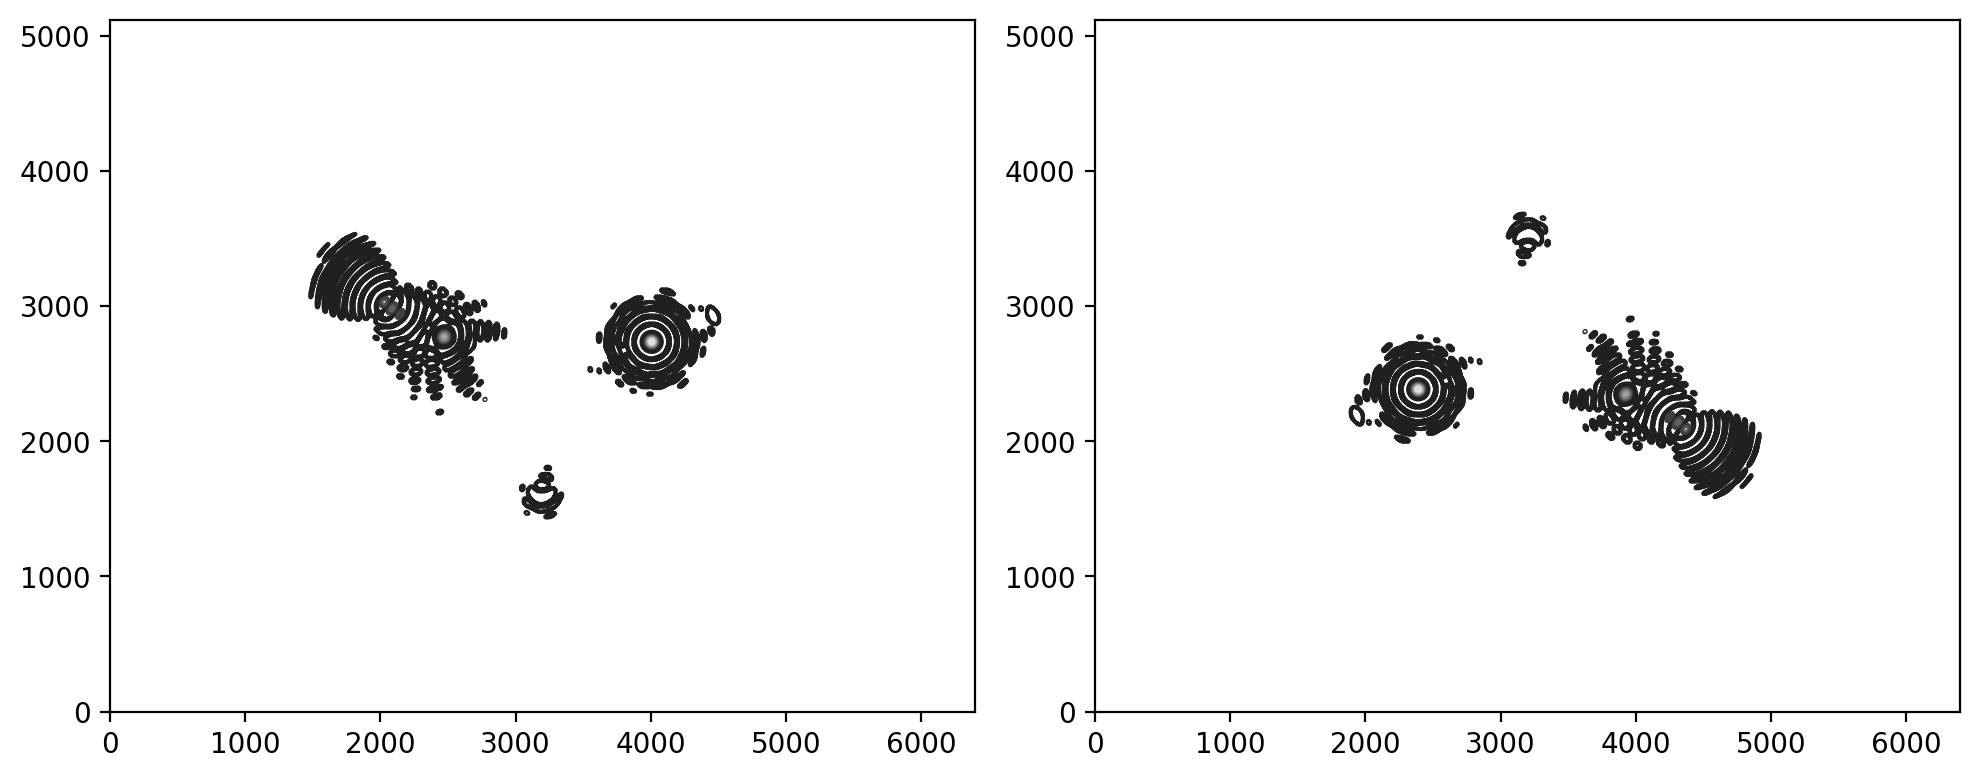

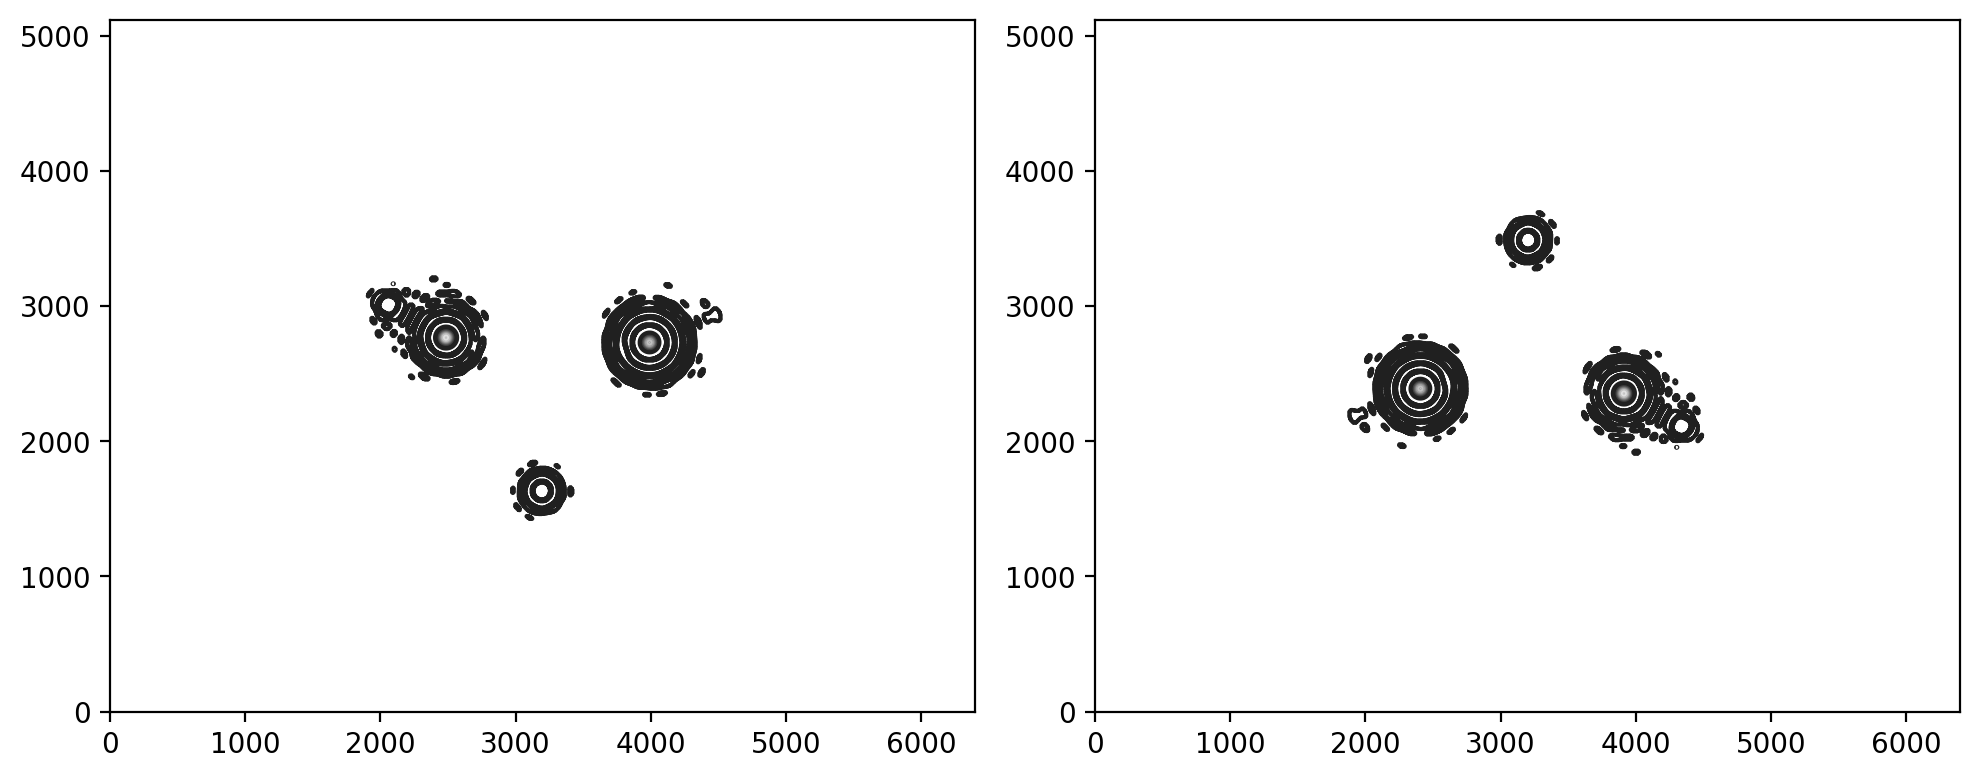

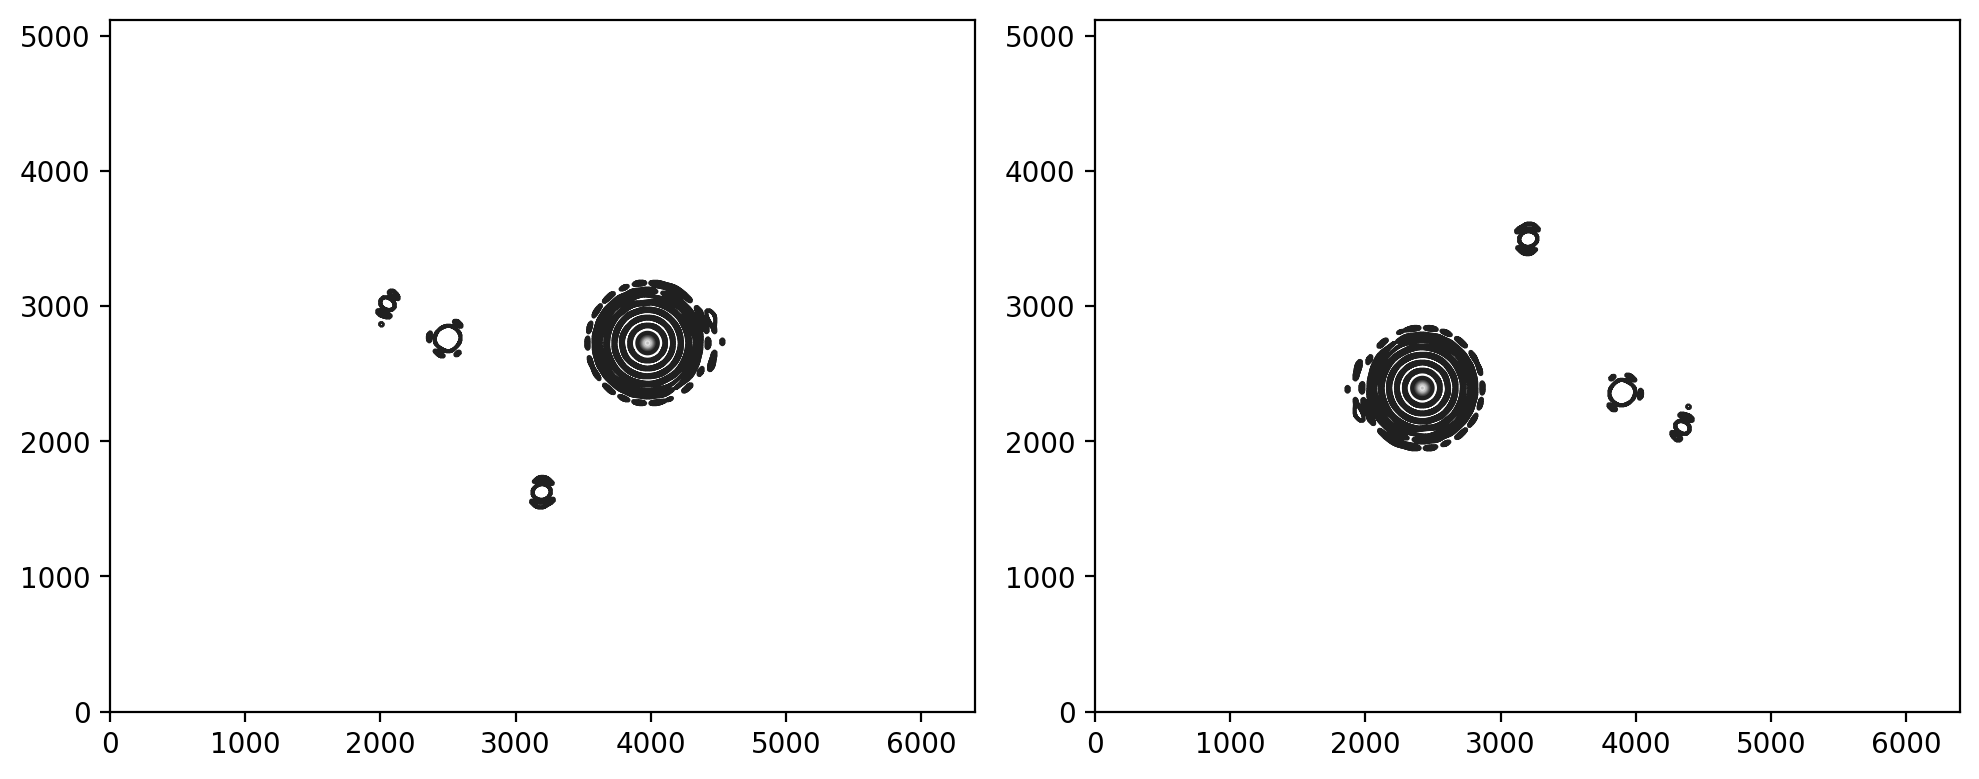

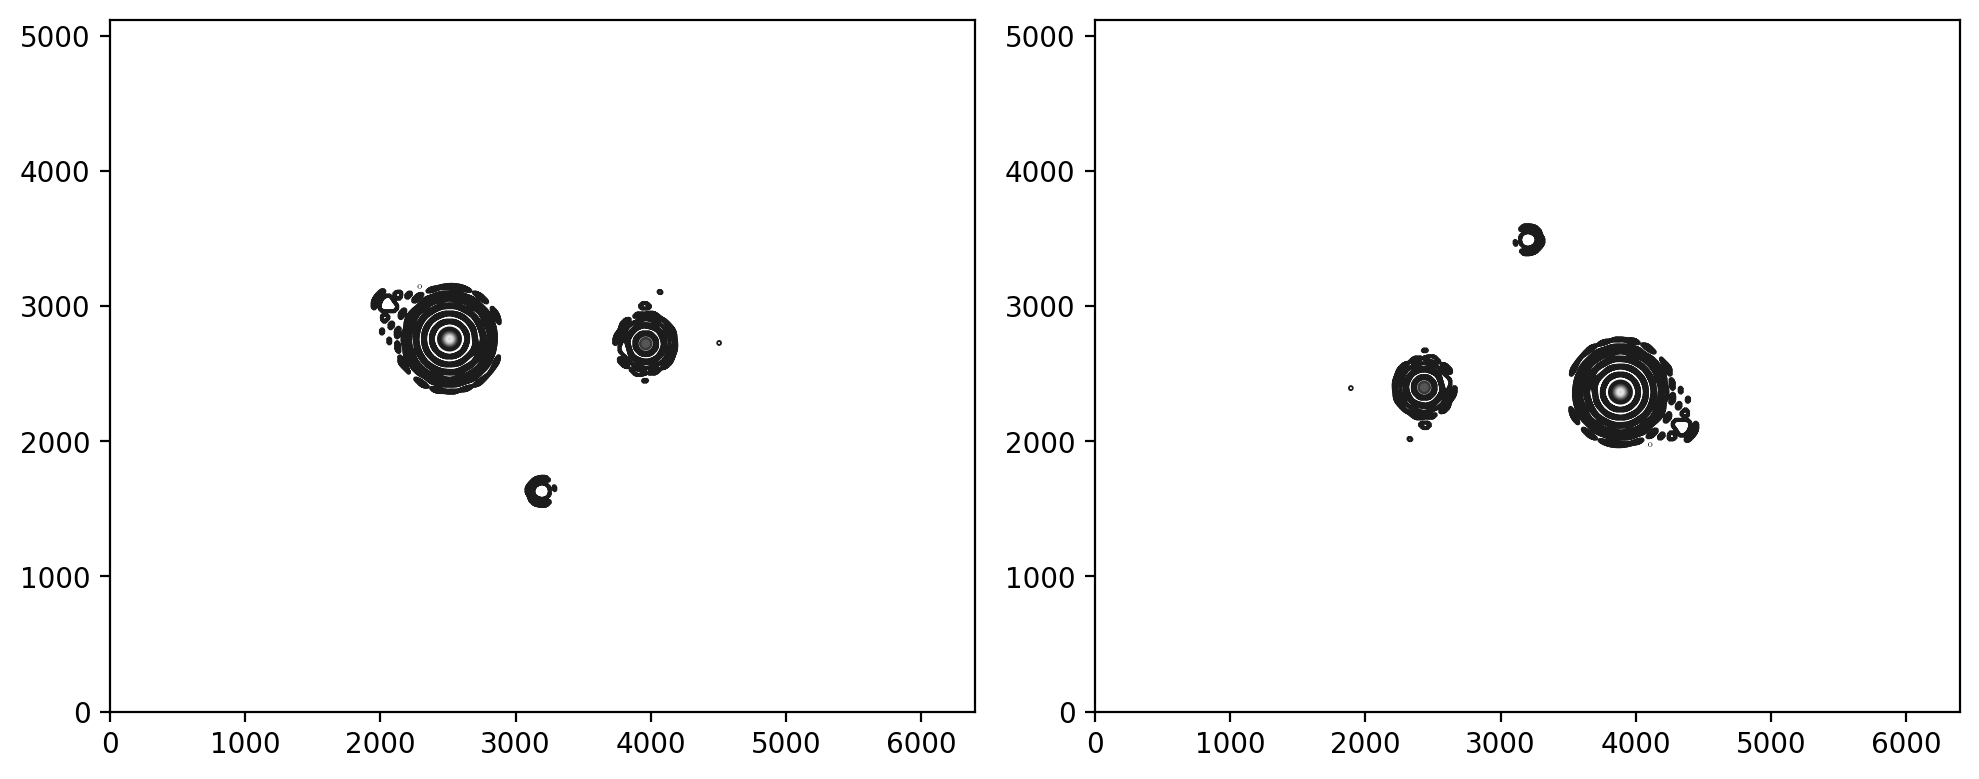

In [33]:
for i in range(len(depths)):
    figure6 = plt.figure(figsize=(10,10))
    figure6.set_tight_layout(True)
    ax1, ax2 = figure6.subplots(1,2)
    ax1.set_aspect(len(forward_test[:,:,i])/len(forward_test[:,i,0]))
    ax2.set_aspect(len(backward_test[:,:,i])/len(backward_test[:,i,0]))
    ax1.contour(forward_test[:,:,i].cpu().numpy().astype(np.float16), cmap = 'gray')
    ax2.contour(backward_test[:,:,i].cpu().numpy().astype(np.float16), cmap = 'gray')
    figure6.savefig(r'/Users/halensolomon/Code/FLFM_local/testing/forward_backward_test' + str(i) + '.png', dpi = 200)

In [34]:
def richardson_lucy(e_i, oringinal_image, f, b):
    
    pad = (f[0][0].shape[0] - 1)/2
    pad = int(pad)
    
    kernel_size = f.shape[0]
    func1 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, padding = pad, device = 'mps')
    func1.weight = f
    denom = func1(e_i)
    
    kernel_size = b.shape[0]
    func2 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, padding = pad, device = 'mps')
    func2.weight = b
    factor = func2(oringinal_image/denom)
    
    return e_i * factor

def richardson_lucy_WB(e_i, oringinal_image, f, b):
    
    pad = (f[0][0].shape[0] - 1)/2
    pad = int(pad)
    
    kernel_size = f.shape[0]
    func1 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, padding = pad, device = 'mps')
    func1.weight = f
    denom = func1(e_i)
    
    kernel_size = b.shape[0]
    func2 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, padding = pad, device = 'mps')
    func2.weight = b
    factor = func2(oringinal_image/denom)
    
    return e_i * factor, factor